In [21]:
import rosbag
import os
import sys
import glob
import subprocess
import yaml
import numpy as np
import csv
import math
import re
import pronouncing

# MUST BE RUN IN PYTHON 2 ENVIRONMENT

DEBUG = True
def debug(input):
    if DEBUG:
        print(input)

AUDIO_DATA_FILE = os.getcwd() + '/../recordings/finished_audios_name_score.csv'
#ROSBAG_DATA_PATH = '/media/prg/1F3F-B8F0/rosbag/'
ROSBAG_DATA_PATH = os.getcwd() + '/../rosbag/'
PARTICIPANT_IDS = ['p03', 'p05', 'p06', 'p08', 'p09', 'p11', 'p12', 'p15', 'p16', 'p17', 'p19', 'p21', 'p22', 'p23', 'p24']

GLOBAL_BAG_DICT = {}
AUDIO_DATA_FILES = []
AUDIO_DATA_SCORES = []


with open(AUDIO_DATA_FILE, 'rb') as csvfile:
    audio_data = csv.reader(csvfile)

    for row in audio_data:
        AUDIO_DATA_FILES.append(row[0])
        AUDIO_DATA_SCORES.append(float(row[1]))                

for pid in PARTICIPANT_IDS:
    practice_bags = glob.glob(ROSBAG_DATA_PATH + pid + '/*_practice_*.bag')
    experiment_bags = glob.glob(ROSBAG_DATA_PATH + pid + '/*_experiment_*.bag')
    posttest_bags = glob.glob(ROSBAG_DATA_PATH + pid + '/*_posttest_*.bag')
    GLOBAL_BAG_DICT[pid + '_practice'] = practice_bags
    GLOBAL_BAG_DICT[pid + '_experiment'] = experiment_bags
    GLOBAL_BAG_DICT[pid + '_posttest'] = posttest_bags
    #debug(pid)
    #debug(len(experiment_bags))
    #debug(len(posttest_bags))
    #debug('-----')
    
debug(GLOBAL_BAG_DICT)


{'p09_experiment': ['/home/prg/catkin_ws/src/unity-game-controllers/notebooks/../rosbag/p09/p09_sam_experiment_2017-10-28-17-23-46.bag'], 'p09_posttest': ['/home/prg/catkin_ws/src/unity-game-controllers/notebooks/../rosbag/p09/p09_sam_posttest_2017-10-28-17-34-49.bag'], 'p17_experiment': ['/home/prg/catkin_ws/src/unity-game-controllers/notebooks/../rosbag/p17/p17_huili_experiment_2017-11-02-02-46-42.bag'], 'p23_experiment': ['/home/prg/catkin_ws/src/unity-game-controllers/notebooks/../rosbag/p23/p23_sam_experiment_2017-11-06-17-55-16.bag'], 'p19_experiment': ['/home/prg/catkin_ws/src/unity-game-controllers/notebooks/../rosbag/p19/p19_huili_experiment_2017-11-04-13-45-59.bag'], 'p06_experiment': ['/home/prg/catkin_ws/src/unity-game-controllers/notebooks/../rosbag/p06/p06_sam_experiment_2017-10-28-15-01-39.bag'], 'p24_experiment': ['/home/prg/catkin_ws/src/unity-game-controllers/notebooks/../rosbag/p24/p24_sam_experiment_2017-11-06-18-35-21.bag'], 'p16_experiment': ['/home/prg/catkin_ws/

In [22]:
 def summarize_bag(bag, bag_path):

        debug("SUMMARIZING BAG")
        debug(bag)


        bag_info_dict = yaml.load(subprocess.Popen(['rosbag', 'info', '--yaml', bag_path],
         stdout=subprocess.PIPE).communicate()[0])
        debug("heres a handy info dict about the bag")
        debug(bag_info_dict)

        topics = bag.get_type_and_topic_info()[1].keys()
        types = []

        for i in range(0, len(bag.get_type_and_topic_info()[1].values())):
            types.append(bag.get_type_and_topic_info()[1].values()[i][0])

        debug('------------')

        debug("total message count")
        debug(bag.get_message_count())
        debug('------------')
        for i in range(len(topics)):
            debug("topic \"" + str(topics[i]) + "\" message count")
            debug(str(bag.get_message_count(topics[i])) + " messages")
            debug("of type " + types[i])
            debug('------------')

bagpath = GLOBAL_BAG_DICT['p16' + '_posttest'][0]
bag = rosbag.Bag(bagpath)        
summarize_bag(bag, bagpath)


#for pid in PARTICIPANT_IDS:
#    summarize_bag(GLOBAL_BAG_DICT[pid + '_experiment'])

SUMMARIZING BAG
path:        /home/prg/catkin_ws/src/unity-game-controllers/notebooks/../rosbag/p16/p16_huili_posttest_2017-11-02-02-21-40.bag
version:     2.0
duration:    5:39s (339s)
start:       Nov 01 2017 23:21:42.81 (1509603702.81)
end:         Nov 01 2017 23:27:22.41 (1509604042.41)
size:        263.1 MB
messages:    10334
compression: none [346/346 chunks]
types:       jibo_msgs/JiboAction                [c7a76c86ad9c2115ce61664c08c9fb8d]
             sensor_msgs/CompressedImage         [8f7a12909da2c9d3332d540a0977563f]
             unity_game_msgs/TapGameCommand      [3e6bc7d38de4396a9396897485733d5a]
             unity_game_msgs/TapGameLog          [60195735725f8d5081ba9dd4343e9a2b]
             unity_game_msgs/TapGameRoundSummary [d6261a2f2b3d738543e314fb6f20e7e7]
topics:      /jibo                              15 msgs @  0.1 Hz : jibo_msgs/JiboAction               
             /tap_game_from_ros                 64 msgs @  0.3 Hz : unity_game_msgs/TapGameCommand     
    

In [49]:
## This module will rectify bags!

## That means, combining pids with experiments spread across multiple bags

## It also means looking at messages with all-zero scores (indicative of bad speechace results) and
## re-running them through SpeechAce to get a new score, and retraining the GP's after that


import time 
import json

myUtils = PronunciationUtils()

def speechace(audio_file, expected_text):
    """
    Takes the audiofile and uses the text it is supposed to match; returns a
    score and the time elapsed to calculate the score.
    """
    start_time = time.time()

    # send request to speechace api
    api_command = "curl --form text='" + expected_text + "' --form user_audio_file=@" + audio_file + " --form dialect=general_american --form user_id=1234 \"https://api.speechace.co/api/scoring/text/v0.2/json?key=po%2Fc4gm%2Bp4KIrcoofC5QoiFHR2BTrgfUdkozmpzHFuP%2BEuoCI1sSoDFoYOCtaxj8N6Y%2BXxYpVqtvj1EeYqmXYSp%2BfgNfgoSr5urt6%2FPQzAQwieDDzlqZhWO2qFqYKslE&user_id=002\"" # pylint: disable=line-too-long
#     process = subprocess.Popen(api_command, shell=True, stdout=subprocess.PIPE,
#                                stderr=subprocess.STDOUT)  
#     process.wait()
#     pouts = process.stdout.readlines()

    pouts = subprocess.check_output(api_command, shell=True)
    
    #print("RESULT")
    #print(pouts)

    elapsed_time = time.time() - start_time
    print("took " + str(elapsed_time) + " seconds to get speechAce results")

    # decode json outputs from speechace api
    #json.loads(pouts)
    try:
        #print('json loads')
        #print(type(pouts))
        #print(json.loads(pouts))
        result = json.loads(pouts)['text_score']        
        result_text = result['text']
        result_qualityScore = result['quality_score']
        result_word_score_list = result['word_score_list']

        return result_word_score_list
    except: #pylint: disable= bare-except
        try:
            print("TRYING BACKUP METHOD OF PARSING")            
            result = json.loads(pouts)
            #print(json_2)
            # split on 300k, combine parts 3 and 4
        except:
            print("EVEN OUR BACKUP PARSE DID NOT GET VALID RESPONSE")
            return
        
def rectify_speechace_bag(exp_bag, bag_pid):
    """
    corrects invalid SpeechAce results (manifested as all-zero scores) in bags
    """
    
    summary_msgs = []
    final_bag_msgs = [] #indexed by round, these are the rectified messages
    # read all messages
    for topic, msg, time in exp_bag.read_messages():            
            # get all experimental rounds that the human won
            if topic == '/tap_game_round_summary' and not msg.audio_file == 'None':
                summary_msgs.append(msg)

    print("FOUND " + str(len(summary_msgs)) + " SUMMARY MESSAGES BEFORE RECTIFYING")
    #iterate through scores in messages to find the zero messages
    
    for msg in summary_msgs:
        #print("AT START OF RECTIFICATION WORD MEANS LENGTH: " + str(len(msg.word_means)))
        
        nonzero_score_found = False #flag
        
        avg_phone_score = (sum(msg.scores) / len(msg.scores))
        for score in msg.scores:
            if not score == 0.0:
                nonzero_score_found = True
        
        if not nonzero_score_found or True: #uncomment or True to recalc ALL audio, not just 0 score recordings
            print(str(msg.round_index) + ": AVG PHONE SCORE RECTIFYING SPEECHACE WAS " + str(avg_phone_score))
            audio_file = msg.audio_file.split('/')[-1]
            
            #re-assign audio pids for p21 bag
            if bag_pid == 'p21':
                audio_file = audio_file.replace('p04', 'p21')
                msg.audio_file = msg.audio_file.replace('p04', 'p21')
                audio_file = audio_file.replace('p00', 'p21')
                msg.audio_file = msg.audio_file.replace('p00', 'p21')
                print("Re-Assigning p21 in exp_bag")
                print(audio_file)
                print(msg.audio_file)
                
            
            pid = audio_file.split('_')[0]
            word = audio_file.split('_')[3]
            word_score_list = speechace('../recordings/' + str(pid) + '/' + audio_file, word)

            if word_score_list:
                for word_results in word_score_list:
                    letters, passed, scores = \
                        myUtils.process_speechace_word_results(word_results)
                    
                    msg.letters = [letter.encode('ascii', 'ignore') for letter in letters]
                    avg_phone_score = (sum(scores) / len(scores))
                    print(str(msg.round_index) + ": NEW PHONE SCORE RECTIFYING SPEECHACE IS " + str(avg_phone_score))
                    msg.scores = scores
                    msg.passed = passed
            else:
                print("STILL BAD OUTPUT FROM SPEECHACE")
        #print("At end OF RECTIFICATION WORD MEANS LENGTH: " + str(len(msg.word_means)))
        final_bag_msgs.append(msg)
            
    return final_bag_msgs

def rectify_gp(rectified_msgs):
    """
    retrains the word and phoneme GP's from scratch, using the new rectified msgs
    """
    
    final_bag_msgs = []
    student_word_model = StudentWordModel()
    student_phoneme_model = StudentPhonemeModel()
    #print("ORIG CURRICULUM FOR BAG IS")
    #print(rectified_msgs[0].word_curriculum)
    #print(len(rectified_msgs[0].word_curriculum))
    
    student_word_model.curriculum = rectified_msgs[0].word_curriculum

    #print("CURRENT CURRICULUM FOR BAG IS")
    #print(student_word_model.curriculum)
    #print(len(student_word_model.curriculum))
    
    for msg in rectified_msgs:        
        
        #print("AT START OF GP RECTIFICATION WORD MEANS LENGTH: " + str(len(msg.word_means)))

        avg_phone_score = (sum(msg.scores) / len(msg.scores))
        #print(str(msg.round_index) + ": AVG PHONE SCORE  RECTIFYING GP " + str(avg_phone_score))
        word_means, word_variances = student_word_model.train_and_compute_posterior([msg.current_round_word],
                                                                                 [avg_phone_score / 100.0])

        phonemes_raw = pronouncing.phones_for_word(msg.current_round_word.lower())[0].split(' ')
        arpabet_phonemes = [''.join(filter(lambda c: not c.isdigit(), pho)) for pho in phonemes_raw]
        #print("ARPABET PHONEME FOR ROUND")
        #print(arpabet_phonemes)
        #print(msg.scores)

        #student_phoneme_model.words_so_far.append(msg.current_round_word) #tell the phoneme model which word for active learning

        phoneme_means, phoneme_vars = student_phoneme_model.train_and_compute_posterior(arpabet_phonemes, [x / 100.0 for x in msg.scores])
        
#         for i in range(0, len(word_means)):
#             print(word_means[i] - msg.word_means[i])
#         print('-----------------')

        msg.word_means = word_means
        msg.word_variances = word_variances

        msg.phoneme_means = phoneme_means
        msg.phoneme_variances = phoneme_vars
        #print("AT END OF GP RECTIFICATION WORD MEANS LENGTH: " + str(len(msg.word_means)))

        final_bag_msgs.append(msg)            
    return final_bag_msgs
                

In [50]:
def phoneme_score_from_word(final_msg, word):
    """
    gets the phoneme-based mean of a word, given the current model
    """
    phonemes_raw = pronouncing.phones_for_word(word.lower())[0].split(' ')
    phonemes = [''.join(filter(lambda c: not c.isdigit(), pho)) for pho in phonemes_raw]

    phoneme_means = []
    for i in range(0, len(phonemes)):
        for j in range(0, len(final_msg.phoneme_curriculum)):
            if phonemes[i] == final_msg.phoneme_curriculum[j]:
                phoneme_means.append(final_msg.phoneme_means[j])        
    #debug('PHONEME MEANS FOR ' + word)
    #debug(phoneme_means)
    return np.mean(phoneme_means)

def analyze_round_summaries(exp_final_message, post_bag, post_bag_pid):
                        
        post_summary_msgs = []
        post_audios = []
     
        # collect ALL recordings from the posttest (to be cross-refd with results)
        for topic, msg, time in post_bag.read_messages():
            
            if topic == '/tap_game_round_summary' and not msg.audio_file == 'None':
                # regex to match for pid and word in ground truth results
                match_string = pid + '.*posttest.*' + msg.current_round_word + '.*wav'
                r = re.compile(match_string)

                #Ground truth audio matches in our results file
                gt_audio_matches = filter(r.match, AUDIO_DATA_FILES)

                # make sure we only add the summary and audio messages
                if not len(gt_audio_matches) == 1:
                    print(match_string)
                    print(gt_audio_matches)
                    print("IRREGULARITY DETECTED IN RESULTS ?!?!?")
                
                else:
                    
                    if post_bag_pid == 'p21':                        
                        msg.audio_file = msg.audio_file.replace('p00', 'p21')
                        print("Re-Assigning p21 in post")
                        print(msg.audio_file)
                    post_summary_msgs.append(msg)
                    post_audios.append(msg.audio_file)
            #else:
            #    print('not a summary message')
                
        debug("FOUND " + str(len(post_summary_msgs)) + " MSGS in POSTTEST")
                
        word_scores, phoneme_scores, ground_truth_ratings, speechace_scores = get_all_scores_and_ratings(post_summary_msgs, exp_final_msg)      
        return word_scores, phoneme_scores, ground_truth_ratings, speechace_scores
        
def get_all_scores_and_ratings(post_msgs, final_msg):
    
    word_scores = []
    phoneme_scores = []
    ground_truth_ratings = []
    speechace_scores = []
    
    for post_msg in post_msgs:
        audio_data_candidate = post_msg.audio_file.split('/')[-1]
        pid = audio_data_candidate.split('_')[0]
        word = audio_data_candidate.split('_')[3]
        
        word_index = final_msg.word_curriculum.index(word)
        if (word_index == -1):
            print("WORD INDEX WAS -1. WTF!")
        
        word_scores.append(final_msg.word_means[word_index])
        phoneme_scores.append(phoneme_score_from_word(final_msg, word))
        
        # regex to match for pid and word in ground truth results
        r = re.compile(pid + '.*posttest.*' + word + '.*wav')
              
        #Ground truth audio matches in our results file
        gt_audio_matches = filter(r.match, AUDIO_DATA_FILES)
        if not len(gt_audio_matches) == 1:
            print(gt_audio_matches)
            print("AUDIO FILE HAD NO MATCH IN RESULTS")
            #print(AUDIO_DATA_FILES)
            return 0,0,0,0,0,0,0,0

        if gt_audio_matches[0] in AUDIO_DATA_FILES:
            gt_match = gt_audio_matches[0]            
            gt_index = AUDIO_DATA_FILES.index(gt_match)                        
            ground_truth_ratings.append(AUDIO_DATA_SCORES[gt_index])
            
            pid = gt_match.split('_')[0]
            word = gt_match.split('_')[3]
            
            #UNCOMMENT TO GET SPEECHACE SCORES FROM SCRATCH
            word_score_list = speechace('../recordings/' + str(pid) + '/' + gt_match, word)
            if word_score_list:
                for word_results in word_score_list:
                    letters, passed, scores = \
                        myUtils.process_speechace_word_results(word_results)
                        
                    speechace_scores.append(scores)
        else:
            print("NO GROUND TRUTH RATING IN OUR DATASET")
            
            
    if not (len(word_scores) == len(phoneme_scores)) and (len(phoneme_scores) == len(ground_truth_ratings)):
        print("MISMATCH IN SCORE LENGTHS AT CONSTRUCTION TIME!!!!")
    return word_scores, phoneme_scores, ground_truth_ratings, speechace_scores
        
        
    

# def calculate_round_loss(word_scores, phoneme_scores, ground_truth_ratings):
#         """
#         computes several different forms of loss of speechace results compared to MTurk audio results
#         """

#         total_word_ceiling_loss = []
#         total_word_floor_loss = []
#         total_word_rounded_loss = []
#         total_word_no_change_loss = []
        
#         total_phoneme_ceiling_loss = []
#         total_phoneme_floor_loss = []
#         total_phoneme_rounded_loss = []
#         total_phoneme_no_change_loss = []
        
#         if not (len(word_scores) == len(phoneme_scores)) and (len(phoneme_scores) == len(ground_truth_ratings)):
#             print("MISMATCH IN SCORE LENGTHS AT EVAL TIME!!!!")
        
#         for i in range(0, len(ground_truth_ratings)):
              
# #             binned_word_score = word_scores[i] * 100 / 20.0
# #             binned_phoneme_score = phoneme_scores[i] * 100 / 20.0
# #             ground_truth_rating = ground_truth_ratings[i]

#             binned_word_score = 1 if word_scores[i] > 0.4 else 0
#             binned_phoneme_score = 1 if phoneme_scores[i] > 0.4 else 0
#             ground_truth_rating = 1 if ground_truth_ratings[i] > 3 else 0
            

#             #debug("GROUND TRUTH WAS") 
#             #debug(ground_truth_rating)
#             #debug("POSTERIOR WORD SCORE WAS")
#             #debug(binned_word_score)
#             #debug("POSTERIOR PHONEME SCORE WAS")
#             #debug(binned_phoneme_score)
#             #debug('-------')

#             # UNCOMMENT TO USE L1 LOSS
#             word_no_change_loss = abs(binned_word_score - ground_truth_rating)
#             word_ceiling_loss = abs(math.ceil(binned_word_score) - ground_truth_rating)
#             word_floor_loss = abs(math.floor(binned_word_score) - ground_truth_rating)
#             word_rounded_loss = abs(round(binned_word_score) - ground_truth_rating)
            
#             phoneme_no_change_loss = abs(binned_phoneme_score - ground_truth_rating)
#             phoneme_ceiling_loss = abs(math.ceil(binned_phoneme_score) - ground_truth_rating)
#             phoneme_floor_loss = abs(math.floor(binned_phoneme_score) - ground_truth_rating)
#             phoneme_rounded_loss = abs(round(binned_phoneme_score) - ground_truth_rating)

#             # UNCOMMENT TO USE L2 LOSS
#             #no_change_word_loss = (binned_word_score - ground_truth_rating)**2
#             #ceiling_word_loss = (math.ceil(binned_word_score) - ground_truth_rating)**2
#             #floor_word_loss = (math.floor(binned_word_score) - ground_truth_rating)**2
#             #rounded_word_loss = (round(binned_word_score) - ground_truth_rating)**2

#             #print(ceiling_word_loss)
#             #print(floor_word_loss)
#             #print(rounded_word_loss)
            
#             total_word_ceiling_loss.append(word_ceiling_loss)
#             total_word_floor_loss.append(word_floor_loss)
#             total_word_rounded_loss.append(word_rounded_loss)
#             total_word_no_change_loss.append(word_no_change_loss)
            
#             total_phoneme_ceiling_loss.append(phoneme_ceiling_loss)
#             total_phoneme_floor_loss.append(phoneme_floor_loss)
#             total_phoneme_rounded_loss.append(phoneme_rounded_loss)
#             total_phoneme_no_change_loss.append(phoneme_no_change_loss)

#         return total_word_ceiling_loss, total_word_floor_loss, total_word_rounded_loss, total_word_no_change_loss, total_phoneme_ceiling_loss, total_phoneme_floor_loss, total_phoneme_rounded_loss, total_phoneme_no_change_loss



In [ ]:
#### Rectify all EXPERIMENTAL bags here
speechace_rectified_msgs = []
#for pid in ['p09']:
for pid in PARTICIPANT_IDS:
    print('------------')
    print("RECTIFYING PID " + str(pid))
    post_bagpaths = GLOBAL_BAG_DICT[pid + '_posttest']
    exp_bagpaths = GLOBAL_BAG_DICT[pid + '_experiment']
    
    for bagpath in exp_bagpaths:
        
        og_summary_msgs = []
        rectified_msgs = []
        new_gp_msgs = []
        # read all messages
        exp_bag = rosbag.Bag(bagpath)

        for topic, msg, timestamp in exp_bag.read_messages():            
            # get all experimental rounds that the human won
            if topic == '/tap_game_round_summary' and not msg.audio_file == 'None':
                og_summary_msgs.append(msg)
                
        rectified_msgs = rectify_speechace_bag(exp_bag, pid)        
        print(len(og_summary_msgs[-1].word_means))
        print(len(rectified_msgs[-1].word_means))
        speechace_rectified_msgs.append(rectified_msgs)

        


------------
RECTIFYING PID p03
FOUND 19 SUMMARY MESSAGES BEFORE RECTIFYING
1: AVG PHONE SCORE RECTIFYING SPEECHACE WAS 0.0
took 2.81661987305 seconds to get speechAce results
b-Rd
1: NEW PHONE SCORE RECTIFYING SPEECHACE IS 51.1142469087
2: AVG PHONE SCORE RECTIFYING SPEECHACE WAS 67.0309829712
took 2.58253788948 seconds to get speechAce results
dI-r
IY DID NOT MATCH IH
IY DID NOT MATCH R
2: NEW PHONE SCORE RECTIFYING SPEECHACE IS 3.5
3: AVG PHONE SCORE RECTIFYING SPEECHACE WAS 0.0
took 2.72192597389 seconds to get speechAce results
bo-l
3: NEW PHONE SCORE RECTIFYING SPEECHACE IS 63.1296198055
4: AVG PHONE SCORE RECTIFYING SPEECHACE WAS 97.9114961624
took 2.53621196747 seconds to get speechAce results
kxmpYt-R
4: NEW PHONE SCORE RECTIFYING SPEECHACE IS 96.5974010943
6: AVG PHONE SCORE RECTIFYING SPEECHACE WAS 44.4081475394
took 3.02892303467 seconds to get speechAce results
me-lbaX
6: NEW PHONE SCORE RECTIFYING SPEECHACE IS 81.120934509
7: AVG PHONE SCORE RECTIFYING SPEECHACE WAS 91.93

took 2.6330280304 seconds to get speechAce results
hcrs-
16: NEW PHONE SCORE RECTIFYING SPEECHACE IS 94.6217576029
17: AVG PHONE SCORE RECTIFYING SPEECHACE WAS 37.8992276986
took 2.69357085228 seconds to get speechAce results
pe-ntIG-
17: NEW PHONE SCORE RECTIFYING SPEECHACE IS 47.3005952381
18: AVG PHONE SCORE RECTIFYING SPEECHACE WAS 10.9085648855
took 2.16577100754 seconds to get speechAce results
Ar-N
18: NEW PHONE SCORE RECTIFYING SPEECHACE IS 17.7777777778
19: AVG PHONE SCORE RECTIFYING SPEECHACE WAS 97.4151509603
took 2.73154592514 seconds to get speechAce results
mW-s-
19: NEW PHONE SCORE RECTIFYING SPEECHACE IS 97.4937707641
20: AVG PHONE SCORE RECTIFYING SPEECHACE WAS 74.1466496785
took 2.12737607956 seconds to get speechAce results
C-E-r
20: NEW PHONE SCORE RECTIFYING SPEECHACE IS 46.2313190383
21: AVG PHONE SCORE RECTIFYING SPEECHACE WAS 69.9363690615
took 3.97707700729 seconds to get speechAce results
kxmpYt-R
21: NEW PHONE SCORE RECTIFYING SPEECHACE IS 74.7848486617
22: A

took 2.43202495575 seconds to get speechAce results
h@t
24: NEW PHONE SCORE RECTIFYING SPEECHACE IS 96.012345679
25: AVG PHONE SCORE RECTIFYING SPEECHACE WAS 67.8858591715
took 2.43742895126 seconds to get speechAce results
go-t
25: NEW PHONE SCORE RECTIFYING SPEECHACE IS 67.7365418895
45
45
------------
RECTIFYING PID p11
FOUND 19 SUMMARY MESSAGES BEFORE RECTIFYING
2: AVG PHONE SCORE RECTIFYING SPEECHACE WAS 83.556060791
took 2.05296587944 seconds to get speechAce results
b-Rd
2: NEW PHONE SCORE RECTIFYING SPEECHACE IS 71.0588235294
3: AVG PHONE SCORE RECTIFYING SPEECHACE WAS 0.0
took 2.5127530098 seconds to get speechAce results
kxmpYt-R
3: NEW PHONE SCORE RECTIFYING SPEECHACE IS 70.3465999278
5: AVG PHONE SCORE RECTIFYING SPEECHACE WAS 0.0
took 2.79884600639 seconds to get speechAce results
me-lbaX
5: NEW PHONE SCORE RECTIFYING SPEECHACE IS 49.0429350269
6: AVG PHONE SCORE RECTIFYING SPEECHACE WAS 77.6396212578
took 2.36671805382 seconds to get speechAce results
klak-
6: NEW PHONE S

In [31]:
a = [{u'extent': [196, 208], u'phone': u'p', u'quality_score': 96.83333333333333, u'sound_most_like': u'ah', u'stress_level': None}, {u'child_phones': [{u'extent': [208, 209], u'quality_score': 11.666666666666666, u'sound_most_like': u'ah'}, {u'extent': [209, 210], u'quality_score': 11.666666666666666, u'sound_most_like': u'ow'}, {u'extent': [210, 212], u'quality_score': 11.666666666666666, u'sound_most_like': u'ah'}], u'stress_level': 1, u'stress_score': 100.0, u'quality_score': 11.666666666666666, u'phone': u'ey', u'extent': [208, 212], u'sound_most_like': u'ah'}, {u'extent': [212, 216], u'phone': u'n', u'quality_score': 35.0, u'sound_most_like': u'l', u'stress_level': None}, {u'child_phones': [{u'extent': [216, 234], u'quality_score': 79.55555555555556, u'sound_most_like': u'd'}, {u'extent': [234, 244], u'quality_score': 39.39999999999998, u'sound_most_like': u'hh'}], u'stress_level': None, u'quality_score': 65.21428571428571, u'phone': u't', u'extent': [216, 244], u'sound_most_like': u'hh'}, {u'child_phones': [{u'extent': [244, 252], u'quality_score': 82.20833333333333, u'sound_most_like': u'eh'}, {u'extent': [252, 262], u'quality_score': 11.483333333333334, u'sound_most_like': u'r'}, {u'extent': [262, 272], u'quality_score': 34.999999999999986, u'sound_most_like': u'er'}], u'stress_level': 0, u'stress_score': 100.0, u'quality_score': 40.089285714285715, u'phone': u'ih', u'extent': [244, 272], u'sound_most_like': u'r'}, {u'extent': [272, 275], u'phone': u'ng', u'quality_score': 35.0, u'sound_most_like': u'th', u'stress_level': None}]
b = [{u'child_phones': [{u'extent': [115, 127], u'quality_score': 98.08333333333333, u'sound_most_like': u'p'}, {u'extent': [127, 130], u'quality_score': 35.0, u'sound_most_like': u'l'}], u'stress_level': None, u'quality_score': 85.46666666666667, u'phone': u'p', u'extent': [115, 130], u'sound_most_like': u'l'}, {u'child_phones': [{u'extent': [130, 131], u'quality_score': 35.0, u'sound_most_like': u'uh'}, {u'extent': [131, 132], u'quality_score': 35.0, u'sound_most_like': u'aa'}], u'stress_level': 1, u'stress_score': 100.0, u'quality_score': 35.0, u'phone': u'ey', u'extent': [130, 132], u'sound_most_like': u'aa'}, {u'child_phones': [{u'extent': [132, 142], u'quality_score': 12.799999999999999, u'sound_most_like': u'ah'}, {u'extent': [142, 146], u'quality_score': 7.708333333333333, u'sound_most_like': u't'}, {u'extent': [146, 149], u'quality_score': 5.833333333333333, u'sound_most_like': u'ch'}, {u'extent': [149, 153], u'quality_score': 5.833333333333333, u'sound_most_like': u'sh'}, {u'extent': [153, 160], u'quality_score': 5.83333333333333, u'sound_most_like': u's'}, {u'extent': [160, 162], u'quality_score': 5.833333333333333, u'sound_most_like': u'sh'}, {u'extent': [162, 164], u'quality_score': 5.833333333333333, u'sound_most_like': u'ch'}], u'stress_level': None, u'quality_score': 8.244791666666666, u'phone': u'n', u'extent': [132, 164], u'sound_most_like': u's'}, {u'child_phones': [{u'extent': [164, 165], u'quality_score': 20.0, u'sound_most_like': u'sh'}, {u'extent': [165, 166], u'quality_score': 0.0, u'sound_most_like': u'ch'}, {u'extent': [166, 167], u'quality_score': 25.0, u'sound_most_like': u'ih'}, {u'extent': [167, 168], u'quality_score': 24.0, u'sound_most_like': u'eh'}, {u'extent': [168, 169], u'quality_score': 9.75, u'sound_most_like': u'ae'}, {u'extent': [169, 171], u'quality_score': 10.416666666666666, u'sound_most_like': u'eh'}, {u'extent': [171, 173], u'quality_score': 9.75, u'sound_most_like': u'ae'}], u'stress_level': 0, u'stress_score': 100.0, u'quality_score': 13.231481481481481, u'phone': u'ih', u'extent': [164, 173], u'sound_most_like': u'ae'}, {u'child_phones': [{u'extent': [173, 176], u'quality_score': 5.0, u'sound_most_like': u'r'}, {u'extent': [176, 179], u'quality_score': 1.746031746031746, u'sound_most_like': u'aw'}, {u'extent': [179, 180], u'quality_score': 5.0, u'sound_most_like': u'r'}, {u'extent': [180, 186], u'quality_score': 2.1825396825396823, u'sound_most_like': u'ae'}, {u'extent': [186, 187], u'quality_score': 5.0, u'sound_most_like': u'r'}, {u'extent': [187, 189], u'quality_score': 2.619047619047619, u'sound_most_like': u'ae'}, {u'extent': [189, 195], u'quality_score': 5.0, u'sound_most_like': u'k'}, {u'extent': [195, 198], u'quality_score': 9.761904761904761, u'sound_most_like': u'r'}], u'stress_level': None, u'quality_score': 4.314285714285714, u'phone': u'ng', u'extent': [173, 198], u'sound_most_like': u'ae'}]
print(len(a))
print(len(b))
for i in range(0,len(a)):
    print(a[i]['phone'])
    print(b[i]['phone'])

6
5
p
p
ey
ey
n
n
t
ih
ih
ng
ng


IndexError: list index out of range

In [15]:
import pickle
SAVE = False
LOAD = True
PIK = "rectified_exp_messages.dat"

speechace_rectified_msgs_master = []

if (SAVE):
    speechace_rectified_msgs_master = speechace_rectified_msgs
    with open(PIK, "wb") as f:
        pickle.dump(speechace_rectified_msgs_master, f)
if(LOAD):
    with open(PIK, "rb") as f:
        speechace_rectified_msgs_master = pd.read_pickle(f)

print(len(speechace_rectified_msgs_master))
speechace_rectified_msgs = speechace_rectified_msgs_master

# for i in range(0, len(all_speechace_scores)):
#     speechace_means = [np.mean(x) / 100.0 for x in all_speechace_scores[i]]
#     print(speechace_means)



15


In [16]:
# HERE IS WHERE WE PLAY WITH GP_RECTIFICATION

all_rectified_msgs = []


for message_set in speechace_rectified_msgs:
    
    pid = message_set[0].audio_file.split('/')[-1][0:3]
    print(pid)
    
    new_gp_msgs = rectify_gp(message_set)

    #print(len(rectified_msgs[-1].word_means))
    #print(len(og_summary_msgs[-1].word_means))
    #print(len(new_gp_msgs[-1].word_means))

    all_rectified_msgs.append([pid, new_gp_msgs])

    #print((list(map(operator.sub, og_summary_msgs[-1].word_means, new_gp_msgs[-1].word_means))))
    #print((list(map(operator.sub, og_summary_msgs[-1].phoneme_means, new_gp_msgs[-1].phoneme_means))))
    
print(len(all_rectified_msgs))

p03
p05
p06
p08
p09
p11
p12
p15
p16
p17
p19
p21
p22
p23
p24
15


In [39]:
#### Rectify all POSTTEST bags here
all_rectified_post_msgs = []        
#for pid in ['p21']:
for pid in PARTICIPANT_IDS:
    print('------------')
    print("RECTIFYING PID " + str(pid))
    post_bagpaths = GLOBAL_BAG_DICT[pid + '_posttest']
    exp_bagpaths = GLOBAL_BAG_DICT[pid + '_experiment']
    
    for bagpath in post_bagpaths:
        
        og_summary_msgs = []
        rectified_post_msgs = []
        new_gp_post_msgs = []
        # read all messages
        post_bag = rosbag.Bag(bagpath)

        for topic, msg, timestamp in post_bag.read_messages():            
            # get all experimental rounds that the human won
            if topic == '/tap_game_round_summary' and not msg.audio_file == 'None':
                og_summary_msgs.append(msg)
                
                
        rectified_post_msgs = rectify_speechace_bag(post_bag, pid)
        new_gp_post_msgs = rectify_gp(rectified_post_msgs)
        all_rectified_post_msgs.append([pid, new_gp_post_msgs])
        
        #print((list(map(operator.sub, og_summary_msgs[-1].word_means, new_gp_post_msgs[-1].word_means))))
        #print((list(map(operator.sub, og_summary_msgs[-1].phoneme_means, new_gp_post_msgs[-1].phoneme_means))))

------------
RECTIFYING PID p03
FOUND 44 SUMMARY MESSAGES BEFORE RECTIFYING
[-4.254545604709392e-10, 7.659010536897881e-09, 1.878285915690725e-08, 4.03859553577135e-08, -2.977544855120584e-08, -2.8208910318738845e-08, 7.179343120000681e-09, 5.126546631650797e-09, -3.720180830057984e-09, -1.3307127622042003e-08, -1.2246721858844012e-08, 2.653737074531648e-08, -1.834180568538457e-08, 2.109983676668037e-08, 8.370706794380567e-09, -1.2329278153977441e-08, -9.60843160591196e-09, 4.8346887604466815e-09, -1.294363305426316e-08, 3.8806458935169985e-08, 7.483950126285777e-09, -2.116080510816687e-08, -1.7209939584539313e-08, -1.8234915799553164e-08, 8.706202425656784e-11, 1.7859916212614735e-08, 2.6271552711065738e-09, -8.796609107797337e-09, -7.869180196351522e-09, 1.3944673471488755e-08, 3.597683262412943e-09, -7.467324536492015e-10, -1.0603347089244153e-08, -2.421278955111461e-08, -1.2842639174337478e-08, -2.989800407249277e-08, -3.588192276637869e-08, -2.679610366929097e-08, 2.13145868732667

FOUND 44 SUMMARY MESSAGES BEFORE RECTIFYING
[-8.543131868599119e-09, 1.078537548160341e-08, 2.1844225428502284e-08, -3.008392979175767e-08, -1.3585454761155802e-08, 6.428369503375109e-09, 1.3085152961167523e-08, 1.8144774571737798e-10, -2.5375698209373354e-09, -2.2907857943899046e-08, 1.5107401551972544e-08, 1.9337985879275266e-08, -5.609827047337035e-10, 9.748927332076107e-09, 2.806555676748701e-08, -1.4502797962556713e-08, 8.242411864145538e-09, 1.706604368933995e-08, 1.2311680785970225e-08, -1.1451652404126378e-08, -1.3441539992165019e-08, -3.935733494664362e-08, 9.177722137820865e-09, 7.5314977587837e-09, -2.46997422514994e-09, -1.7981667266298018e-08, -6.972923349835014e-10, 1.9474485912773787e-08, -1.2477923139186942e-09, 2.644442820276538e-08, -2.502025253647844e-10, -4.319812896280695e-09, -1.1907951180667453e-08, 2.9927253675232635e-08, -1.658530734971464e-08, -1.5260562369334707e-08, 1.722152398464516e-08, -1.6311492156972918e-08, 1.5149619891907662e-08, -5.068947817044034e-0

FOUND 15 SUMMARY MESSAGES BEFORE RECTIFYING
29: AVG PHONE SCORE RECTIFYING SPEECHACE WAS 0.0
took 2.64856100082 seconds to get speechAce results
m^D--R
29: NEW PHONE SCORE RECTIFYING SPEECHACE IS 14.1313210736
33: AVG PHONE SCORE RECTIFYING SPEECHACE WAS 0.0
took 2.45503211021 seconds to get speechAce results
ru-st-R
33: NEW PHONE SCORE RECTIFYING SPEECHACE IS 28.5106028708
38: AVG PHONE SCORE RECTIFYING SPEECHACE WAS 0.0
took 2.48716211319 seconds to get speechAce results
stov-
38: NEW PHONE SCORE RECTIFYING SPEECHACE IS 25.0270615714
42: AVG PHONE SCORE RECTIFYING SPEECHACE WAS 0.0
took 2.63188004494 seconds to get speechAce results
xmbrEl-x
42: NEW PHONE SCORE RECTIFYING SPEECHACE IS 36.0848967474
[-0.033414356939086454, -0.042820698189815876, -0.10199945664998533, -0.08283959448242068, -0.05018801610617574, -0.0937622507023943, -0.05650074755048862, -0.10561905474967814, -0.11978402828964074, -0.06745110316276809, -0.04876766085132539, -0.0010799972615505027, -0.05289670108063527, 

took 3.12709784508 seconds to get speechAce results
ru-st-R
33: NEW PHONE SCORE RECTIFYING SPEECHACE IS 43.467057084
34: AVG PHONE SCORE RECTIFYING SPEECHACE WAS 0.0
took 2.35363197327 seconds to get speechAce results
si-l
34: NEW PHONE SCORE RECTIFYING SPEECHACE IS 8.51184611776
36: AVG PHONE SCORE RECTIFYING SPEECHACE WAS 0.0
took 2.28092598915 seconds to get speechAce results
S--Rt
36: NEW PHONE SCORE RECTIFYING SPEECHACE IS 14.1257918552
38: AVG PHONE SCORE RECTIFYING SPEECHACE WAS 0.0
took 2.43176293373 seconds to get speechAce results
stov-
38: NEW PHONE SCORE RECTIFYING SPEECHACE IS 25.3443712755
39: AVG PHONE SCORE RECTIFYING SPEECHACE WAS 0.0
took 2.62579584122 seconds to get speechAce results
s^n
39: NEW PHONE SCORE RECTIFYING SPEECHACE IS 9.20129288701
42: AVG PHONE SCORE RECTIFYING SPEECHACE WAS 0.0
took 2.60782980919 seconds to get speechAce results
xmbrEl-x
42: NEW PHONE SCORE RECTIFYING SPEECHACE IS 53.9810252227
[-0.024922998040577404, -0.020864097344126864, -0.47025539

took 2.43402385712 seconds to get speechAce results
s^n
39: NEW PHONE SCORE RECTIFYING SPEECHACE IS 22.6227964799
40: AVG PHONE SCORE RECTIFYING SPEECHACE WAS 0.0
Re-Assigning p21 in exp_bag
p21_safinah_posttest_TRACTOR_40.wav
GameUtils/PronunciationUtils/data/recordings/p21_safinah_posttest_TRACTOR_40.wav
took 2.45865416527 seconds to get speechAce results
tr@kt-R
40: NEW PHONE SCORE RECTIFYING SPEECHACE IS 51.8812574594
41: AVG PHONE SCORE RECTIFYING SPEECHACE WAS 0.0
Re-Assigning p21 in exp_bag
p21_safinah_posttest_TRAIN_41.wav
GameUtils/PronunciationUtils/data/recordings/p21_safinah_posttest_TRAIN_41.wav
took 2.89993810654 seconds to get speechAce results
tre-n
41: NEW PHONE SCORE RECTIFYING SPEECHACE IS 9.15046188494
[-0.04479292057257017, -0.3166629814845191, -0.012481700673041107, -0.13134802710279236, -0.034640338088091305, 0.00036359248959755286, -0.07160075144993738, -0.012080514377633855, -0.43689436126876646, -0.23931753603967287, -0.01662832503916456, -0.007103110224518927

FOUND 19 SUMMARY MESSAGES BEFORE RECTIFYING
4: AVG PHONE SCORE RECTIFYING SPEECHACE WAS 0.0
took 2.49351000786 seconds to get speechAce results
b^k-xt
4: NEW PHONE SCORE RECTIFYING SPEECHACE IS 34.8805286209
6: AVG PHONE SCORE RECTIFYING SPEECHACE WAS 0.0
took 2.38206100464 seconds to get speechAce results
k@t
6: NEW PHONE SCORE RECTIFYING SPEECHACE IS 54.9830163248
8: AVG PHONE SCORE RECTIFYING SPEECHACE WAS 0.0
took 2.86820983887 seconds to get speechAce results
klak-
8: NEW PHONE SCORE RECTIFYING SPEECHACE IS 4.05262985974
10: AVG PHONE SCORE RECTIFYING SPEECHACE WAS 0.0
took 2.63289284706 seconds to get speechAce results
kxmpYt-R
10: NEW PHONE SCORE RECTIFYING SPEECHACE IS 41.0213672655
13: AVG PHONE SCORE RECTIFYING SPEECHACE WAS 0.0
took 2.58601999283 seconds to get speechAce results
dcg
13: NEW PHONE SCORE RECTIFYING SPEECHACE IS 5.30024787633
14: AVG PHONE SCORE RECTIFYING SPEECHACE WAS 0.0
took 2.55783390999 seconds to get speechAce results
dalf-xn
14: NEW PHONE SCORE RECTIFYI

In [17]:
# This is where we actually compute the loss for each bag
# all_bag_word_loss = []
# all_bag_phoneme_loss = []

# odd_bag_word_loss = []
# odd_bag_phoneme_loss = []

# even_bag_word_loss = []
# even_bag_phoneme_loss = []

all_bag_word_scores = []
all_bag_phoneme_scores = []


odd_bag_word_scores = []
odd_bag_phoneme_scores = []

even_bag_word_scores = []
even_bag_phoneme_scores = []


all_bag_gt = []
odd_bag_gt = []
even_bag_gt = []

all_speechace_scores = []
even_bag_speechace_scores = []
odd_bag_speechace_scores = []


for pid_msg_pair in all_rectified_msgs:    
    print('-----------------------')
    pid = pid_msg_pair[0]
    msgs = pid_msg_pair[1]
    print("ANALYZING PID " + str(pid))

    post_bagpath = GLOBAL_BAG_DICT[pid + '_posttest'][0]        
    post_bag = rosbag.Bag(post_bagpath)
    exp_final_msg = msgs[-1]

    word_scores, phoneme_scores, ground_truth_ratings, speechace_scores = analyze_round_summaries(exp_final_msg, post_bag, pid)    
#     word_ceiling_loss, word_floor_loss, word_rounded_loss, word_no_change_loss, phoneme_ceiling_loss, phoneme_floor_loss, phoneme_rounded_loss, phoneme_no_change_loss, = calculate_round_loss(word_scores, phoneme_scores, ground_truth_ratings)

    print("LENGTH OF SPEECHACE SCORES AND GT RATINGS")
    print(len(speechace_scores))
    print(len(ground_truth_ratings))    
#     all_bag_word_loss.append(word_no_change_loss)
#     all_bag_phoneme_loss.append(phoneme_no_change_loss)

    all_bag_word_scores.append(word_scores)
    all_bag_phoneme_scores.append(phoneme_scores)    
    all_bag_gt.append(ground_truth_ratings)
    all_speechace_scores.append(speechace_scores)

    if int(pid[1:]) % 2 == 1:
        print("USED WORD MODEL FOR ACTIVE LEARNING")
#         odd_bag_word_loss.append(word_no_change_loss)
#         odd_bag_phoneme_loss.append(phoneme_no_change_loss)

        odd_bag_word_scores.append(word_scores)
        odd_bag_phoneme_scores.append(phoneme_scores)
        odd_bag_gt.append(ground_truth_ratings)

        odd_bag_speechace_scores.append(speechace_scores)

    else:
#         even_bag_word_loss.append(word_no_change_loss)
#         even_bag_phoneme_loss.append(phoneme_no_change_loss)

        even_bag_word_scores.append(word_scores)
        even_bag_phoneme_scores.append(phoneme_scores)
        even_bag_gt.append(ground_truth_ratings)
        even_bag_speechace_scores.append(speechace_scores)


-----------------------
ANALYZING PID p03
FOUND 44 MSGS in POSTTEST
took 2.06733202934 seconds to get speechAce results
b-Rd
took 2.24387407303 seconds to get speechAce results
bo-t
took 2.34694314003 seconds to get speechAce results
bo-l
took 1.72040009499 seconds to get speechAce results
bru-m
took 2.19486808777 seconds to get speechAce results
b^k-xt
took 2.33309793472 seconds to get speechAce results
kar
took 2.22783899307 seconds to get speechAce results
k@t
took 2.37199282646 seconds to get speechAce results
C-E-r
took 2.55801987648 seconds to get speechAce results
klak-
took 2.25670599937 seconds to get speechAce results
klW-d
took 2.24830889702 seconds to get speechAce results
kxmpYt-R
took 2.35564804077 seconds to get speechAce results
dI-r
took 2.07016587257 seconds to get speechAce results
dIg
took 2.23410487175 seconds to get speechAce results
dcg
took 2.34301280975 seconds to get speechAce results
dalf-xn
took 2.12311506271 seconds to get speechAce results
faD--R
took 2.28

took 2.26146602631 seconds to get speechAce results
faD--R
took 2.18665599823 seconds to get speechAce results
flW--R
took 2.3113861084 seconds to get speechAce results
frIJ--
took 2.14963006973 seconds to get speechAce results
go-t
took 2.04664707184 seconds to get speechAce results
h@t
took 2.17354297638 seconds to get speechAce results
hcrs-
took 2.22229385376 seconds to get speechAce results
Ar-N
took 2.35960197449 seconds to get speechAce results
kEt-L-
took 2.14784288406 seconds to get speechAce results
l@mp
took 2.19477701187 seconds to get speechAce results
lAxn
took 2.32840895653 seconds to get speechAce results
me-lbaX
took 2.32727098465 seconds to get speechAce results
mIr--R
took 2.07777404785 seconds to get speechAce results
m^Gki-
took 2.32335305214 seconds to get speechAce results
map
took 2.25419592857 seconds to get speechAce results
m^D--R
took 2.16617298126 seconds to get speechAce results
mW-s-
LENGTH OF SPEECHACE SCORES AND GT RATINGS
31
31
-----------------------


took 2.14453101158 seconds to get speechAce results
h@t
took 2.1486890316 seconds to get speechAce results
hcrs-
took 2.15724205971 seconds to get speechAce results
mIr--R
took 2.1447031498 seconds to get speechAce results
m^Gki-
took 2.25294589996 seconds to get speechAce results
map
took 2.12251710892 seconds to get speechAce results
m^D--R
took 2.07107210159 seconds to get speechAce results
mW-s-
took 2.18094015121 seconds to get speechAce results
pe-ntIG-
took 1.62456893921 seconds to get speechAce results
pIg
took 1.79724192619 seconds to get speechAce results
pIl-o-
took 2.18822288513 seconds to get speechAce results
ru-st-R
took 1.82962417603 seconds to get speechAce results
si-l
took 1.8507809639 seconds to get speechAce results
S-i-p
took 1.7253010273 seconds to get speechAce results
S--Rt
took 1.74201893806 seconds to get speechAce results
spu-n
took 2.14711499214 seconds to get speechAce results
stov-
took 2.20854115486 seconds to get speechAce results
s^n
took 2.29685997963

Re-Assigning p21 in post
GameUtils/PronunciationUtils/data/recordings/p21_safinah_posttest_CAR_5.wav
Re-Assigning p21 in post
GameUtils/PronunciationUtils/data/recordings/p21_safinah_posttest_CAT_6.wav
Re-Assigning p21 in post
GameUtils/PronunciationUtils/data/recordings/p21_safinah_posttest_CHAIR_7.wav
Re-Assigning p21 in post
GameUtils/PronunciationUtils/data/recordings/p21_safinah_posttest_CLOCK_8.wav
Re-Assigning p21 in post
GameUtils/PronunciationUtils/data/recordings/p21_safinah_posttest_CLOUD_9.wav
Re-Assigning p21 in post
GameUtils/PronunciationUtils/data/recordings/p21_safinah_posttest_COMPUTER_10.wav
Re-Assigning p21 in post
GameUtils/PronunciationUtils/data/recordings/p21_safinah_posttest_DEER_11.wav
Re-Assigning p21 in post
GameUtils/PronunciationUtils/data/recordings/p21_safinah_posttest_DIG_12.wav
Re-Assigning p21 in post
GameUtils/PronunciationUtils/data/recordings/p21_safinah_posttest_DOG_13.wav
Re-Assigning p21 in post
GameUtils/PronunciationUtils/data/recordings/p21_s

took 4.39888691902 seconds to get speechAce results
map
took 1.72517704964 seconds to get speechAce results
m^D--R
took 2.27163004875 seconds to get speechAce results
mW-s-
took 2.24831008911 seconds to get speechAce results
pIg
took 2.35843706131 seconds to get speechAce results
pIl-o-
took 2.34717988968 seconds to get speechAce results
ru-st-R
took 2.46186804771 seconds to get speechAce results
si-l
took 2.14281511307 seconds to get speechAce results
S-i-p
took 2.359582901 seconds to get speechAce results
S--Rt
took 2.24781417847 seconds to get speechAce results
spu-n
took 2.66221618652 seconds to get speechAce results
stov-
took 2.25016307831 seconds to get speechAce results
s^n
took 6.85777997971 seconds to get speechAce results
tr@kt-R
took 2.46140098572 seconds to get speechAce results
tre-n
took 2.75754117966 seconds to get speechAce results
xmbrEl-x
LENGTH OF SPEECHACE SCORES AND GT RATINGS
43
43
-----------------------
ANALYZING PID p23
FOUND 43 MSGS in POSTTEST
took 2.3338260

In [18]:
import pickle
SAVE = True
LOAD = False
PIK = "speechace_scores.dat"

speechace_master = []
all_bag_gt.append(ground_truth_ratings)

if (SAVE):
    speechace_master = [all_speechace_scores, even_bag_speechace_scores, odd_bag_speechace_scores]
    with open(PIK, "wb") as f:
        pickle.dump(speechace_master, f)
if(LOAD):
    with open(PIK, "rb") as f:
        speechace_master = pickle.load(f)
        all_speechace_scores = speechace_master[0]
        even_bag_speechace_scores = speechace_master[1]
        odd_bag_speechace_scores = speechace_master[2]

# all_speechace_scores[3] = a[3]
# even_bag_speechace_scores[1] = a[3]
print(len(speechace_master))
print(len(all_speechace_scores[3]))
print(len(speechace_master[1][1]))
print(len(speechace_master[2][0]))


# for i in range(0, len(all_speechace_scores)):
#     speechace_means = [np.mean(x) / 100.0 for x in all_speechace_scores[i]]
#     print(speechace_means)


3
31
31
44


In [32]:

# make some graphs!!!!
import matplotlib.pyplot as plt
from sklearn import metrics

GT_class_threshold = 2.0
SA_class_threshold = .66

######### ALL_BAG SPEECHACE TO EXP_SCORE ##############
all_speechace_auc = []
even_speechace_auc = []
odd_speechace_auc = []


######### ALL_BAG SPEECHACE AUC TO GT ##############

all_word_auc = []
all_phoneme_auc = []

odd_word_auc = []
odd_phoneme_auc = []

even_word_auc = []
even_phoneme_auc = []

pos_class_count = 0
neg_class_count = 0

for i in range(0, len(all_speechace_scores)):
    print(i)
    #print(all_speechace_scores[i])
    speechace_means = [np.mean(x) / 100.0 for x in all_speechace_scores[i]]
    bag_ground_truth = [(1 if x > GT_class_threshold else 0) for x in all_bag_gt[i]]

    for x in bag_ground_truth:
        if x == 1:
            pos_class_count += 1
        else:
            neg_class_count +=1
    
    #print(bag_ground_truth)

    if (len(all_bag_gt)) > 1:
        
        # SpeechAce to Ground Truth
        #speechace_fpr, speechace_tpr, thresholds = metrics.roc_curve(bag_ground_truth, speechace_means)
        
        #Word/Phoneme Score to AUC
        #word_fpr, word_tpr, thresholds = metrics.roc_curve(bag_ground_truth, all_bag_word_scores[i])
        #phoneme_fpr, phoneme_tpr, thresholds = metrics.roc_curve(bag_ground_truth, all_bag_phoneme_scores[i])
        
        pid = all_rectified_msgs[i][0]
        print(pid)
        #print("speechace pid was" + str(pid))
        #all_speechace_auc.append(metrics.auc(speechace_fpr, speechace_tpr))
        print("SPEECHACE ROC AND APS")
        print(metrics.roc_auc_score(bag_ground_truth, speechace_means))
        print(metrics.average_precision_score(bag_ground_truth, speechace_means))
        
            
        print("EXP ROC AND APS, WORD, PHONEME")
        print(metrics.roc_auc_score(bag_ground_truth, all_bag_word_scores[i]))
        print(metrics.average_precision_score(bag_ground_truth, all_bag_word_scores[i]))
        print(metrics.roc_auc_score(bag_ground_truth, all_bag_phoneme_scores[i]))
        print(metrics.average_precision_score(bag_ground_truth, all_bag_phoneme_scores[i]))

        all_speechace_auc.append(metrics.average_precision_score(bag_ground_truth, speechace_means))
        all_word_auc.append(metrics.average_precision_score(bag_ground_truth, all_bag_word_scores[i]))
        all_phoneme_auc.append(metrics.average_precision_score(bag_ground_truth, all_bag_phoneme_scores[i]))

        
        if (int(pid[1:]) % 2 == 1):
            #print("adding to odd auc")
            odd_speechace_auc.append(metrics.average_precision_score(bag_ground_truth, speechace_means))
            odd_word_auc.append(metrics.average_precision_score(bag_ground_truth, all_bag_word_scores[i]))
            odd_phoneme_auc.append(metrics.average_precision_score(bag_ground_truth, all_bag_phoneme_scores[i]))
        else:
            even_speechace_auc.append(metrics.average_precision_score(bag_ground_truth, speechace_means))
            even_word_auc.append(metrics.average_precision_score(bag_ground_truth, all_bag_word_scores[i]))
            even_phoneme_auc.append(metrics.average_precision_score(bag_ground_truth, all_bag_phoneme_scores[i]))
        

print("TOTAL CLASS COUNT: POS / NEG")
print(pos_class_count)
print(neg_class_count)
print("SPEECHACE AUC TO GROUND TRUTH")
print(np.mean(all_speechace_auc))
print(np.mean(odd_speechace_auc))
print(np.mean(even_speechace_auc))
print(len(all_speechace_auc))
print(len(odd_speechace_auc))
print(len(even_speechace_auc))
#print(speechace_auc)

######### EVEN BAG AUC ##############



# for i in range(0, len(even_bag_word_scores)):

#     bag_ground_truth = [(1 if x > GT_class_threshold else 0) for x in even_bag_gt[i]]
#     #print(even_bag_gt[i])

#     if (len(bag_ground_truth)) > 1:
#         word_fpr, word_tpr, thresholds = metrics.roc_curve(bag_ground_truth, even_bag_word_scores[i])
#         phoneme_fpr, phoneme_tpr, thresholds = metrics.roc_curve(bag_ground_truth, even_bag_phoneme_scores[i])

#         even_phoneme_auc.append(metrics.auc(phoneme_fpr, phoneme_tpr))
#         even_word_auc.append(metrics.auc(word_fpr, word_tpr))
            
print("EVEN BAG (PHONEME LED) PHONEME AND WORD AUC TO GROUND TRUTH")
print(np.mean(even_phoneme_auc))
print(np.mean(even_word_auc))
print(len(even_phoneme_auc))
print(len(even_word_auc))
#print(even_phoneme_auc)
#print(even_word_auc)

######### ODD BAG AUC ##############



# for i in range(0, len(odd_bag_word_scores)):

#     bag_ground_truth = [(1 if x > GT_class_threshold else 0) for x in odd_bag_gt[i]]
#     #print(odd_bag_gt[i])

#     if (len(bag_ground_truth)) > 1:
#         word_fpr, word_tpr, thresholds = metrics.roc_curve(bag_ground_truth, odd_bag_word_scores[i])
#         phoneme_fpr, phoneme_tpr, thresholds = metrics.roc_curve(bag_ground_truth, odd_bag_phoneme_scores[i])

#         odd_phoneme_auc.append(metrics.auc(phoneme_fpr, phoneme_tpr))
#         odd_word_auc.append(metrics.auc(word_fpr, word_tpr))
            
print("ODD BAG (WORD LED) PHONEME AND WORD AUC TO GROUND TRUTH")
print(np.mean(odd_phoneme_auc))
print(np.mean(odd_word_auc))
print(len(odd_phoneme_auc))
print(len(odd_word_auc))


############### EVEN / ODD AUC to SPEECHACE ################

odd_speechace_word_auc = []
odd_speechace_phoneme_auc = []
even_speechace_word_auc = []
even_speechace_phoneme_auc = []


    
for i in range(0, len(even_bag_speechace_scores)):
    speechace_means = [np.mean(x) / 100.0 for x in even_bag_speechace_scores[i]]
    speechace_labels = [(1 if x > SA_class_threshold else 0) for x in speechace_means]    
    #print(even_speechace_scores[i])
    #print('-----------')
    #print(speechace_labels)
    #print(bag_ground_truth)

    if (len(all_bag_gt)) > 1:
        #fpr, tpr, thresholds = metrics.roc_curve(speechace_labels, even_bag_word_scores[i])
        even_speechace_word_auc.append(metrics.average_precision_score(speechace_labels, even_bag_word_scores[i]))
        #fpr, tpr, thresholds = metrics.precision_recall_curve(speechace_labels, even_bag_phoneme_scores[i])
        even_speechace_phoneme_auc.append(metrics.average_precision_score(speechace_labels, even_bag_phoneme_scores[i]))
        #print(metrics.auc(fpr,tpr))
#print(speechace_means)
#print(speechace_labels)
#print(even_bag_phoneme_scores[-1])

print('ODD BAG SPEECHACE SCORES')
for i in range(0, len(odd_bag_speechace_scores)):

    speechace_means = [np.mean(x) / 100.0 for x in odd_bag_speechace_scores[i]]
    speechace_labels = [(1 if x > SA_class_threshold else 0) for x in speechace_means]   
    #print(odd_speechace_scores[i])
    #print('-----------')
    #print(speechace_labels)
    #print(bag_ground_truth)

    if (len(all_bag_gt)) > 1: # and not pid =='p19'
        #fpr, tpr, thresholds = metrics.precision_recall_curve(speechace_labels, odd_bag_word_scores[i])
        odd_speechace_word_auc.append(metrics.average_precision_score(speechace_labels, odd_bag_word_scores[i]))
        #fpr, tpr, thresholds = metrics.precision_recall_curve(speechace_labels, odd_bag_phoneme_scores[i])
        odd_speechace_phoneme_auc.append(metrics.average_precision_score(speechace_labels, odd_bag_phoneme_scores[i]))
        #print(metrics.auc(fpr,tpr))        

print("EVEN BAG (PHONEME LED) PHONEME AND WORD AUC TO SPEECHACE")
print(np.mean(even_speechace_phoneme_auc))
print(np.mean(even_speechace_word_auc))


print("ODD BAG (WORD LED) PHONEME AND WORD AUC TO SPEECHACE")
print(np.mean(odd_speechace_phoneme_auc))
print(np.mean(odd_speechace_word_auc))

#print(odd_phoneme_auc)
#print(odd_word_auc)

#print(bag_ground_truth

# lw = 2
# plt.plot(word_fpr, word_tpr, color='darkorange',
#          lw=lw, label='ROC curve (area = %0.2f)' % metrics.auc(word_fpr, word_tpr))

# plt.plot(phoneme_fpr, phoneme_tpr, color='b',
#          lw=lw, label='ROC curve (area = %0.2f)' % metrics.auc(phoneme_fpr, phoneme_tpr))
# plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver operating characteristic example')
# plt.legend(loc="lower right")
# plt.show()



0
p03
SPEECHACE ROC AND APS
0.046511627906976744
0.9409443590698661
EXP ROC AND APS, WORD, PHONEME
0.7906976744186046
0.994745477341576
0.9767441860465116
0.9994714587737845
1
p05
SPEECHACE ROC AND APS
0.6666666666666666
0.9772536444390577
EXP ROC AND APS, WORD, PHONEME
0.4166666666666667
0.9600889377220072
0.4166666666666667
0.9593009558625969
2
p06
SPEECHACE ROC AND APS
0.9464285714285715
0.9870436925354524
EXP ROC AND APS, WORD, PHONEME
0.8869047619047619
0.9628235672021426
0.7142857142857143
0.8885589071215028
3
p08
SPEECHACE ROC AND APS
0.7717391304347826
0.9230523607003129
EXP ROC AND APS, WORD, PHONEME
0.7391304347826088
0.8378895348978808
0.40760869565217395
0.6642681567146438
4
p09
SPEECHACE ROC AND APS
0.78125
0.9398228003608291
EXP ROC AND APS, WORD, PHONEME
0.7395833333333334
0.9317912505458157
0.6284722222222222
0.8855122126479418
5
p11
SPEECHACE ROC AND APS
0.8463541666666666
0.9380152122326529
EXP ROC AND APS, WORD, PHONEME
0.5364583333333333
0.7776939789435339
0.640625


SPEECHACE AUC TO GROUND TRUTH
0.8228437607113291
0.042858780906836154
0.8491247352780542
0.04927474292729925
0.7834222988612417
0.08070258849804773
EVEN BAG (PHONEME LED) PHONEME AND WORD AUC TO GROUND TRUTH
0.6479749495598833
0.06354606054217204
0.7721702588963267
0.0714032874126008
ODD BAG (WORD LED) PHONEME AND WORD AUC TO GROUND TRUTH
0.8755591488711957
0.031072225605218537
0.8655512087123052
0.02899709250708867
ALL BAG WORD AND PHONEME AUC
0.8281988287859139
0.03414846778663882
0.7845254691466707
0.042376896726733684


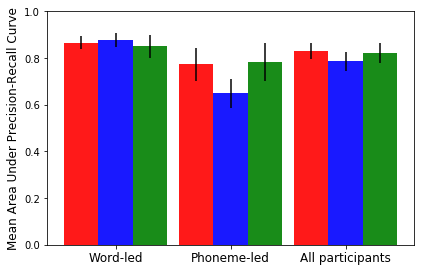

In [25]:
#speechace_auc
#even_speechace_auc
#odd_speechace_auc

from scipy import stats


print("SPEECHACE AUC TO GROUND TRUTH")
print(np.mean(all_speechace_auc))
print(stats.sem(all_speechace_auc))
print(np.mean(odd_speechace_auc))
print(stats.sem(odd_speechace_auc))
print(np.mean(even_speechace_auc))
print(stats.sem(even_speechace_auc))

print("EVEN BAG (PHONEME LED) PHONEME AND WORD AUC TO GROUND TRUTH")
print(np.mean(even_phoneme_auc))
print(stats.sem(even_phoneme_auc))
print(np.mean(even_word_auc))
print(stats.sem(even_word_auc))

print("ODD BAG (WORD LED) PHONEME AND WORD AUC TO GROUND TRUTH")
print(np.mean(odd_phoneme_auc))
print(stats.sem(odd_phoneme_auc))
print(np.mean(odd_word_auc))
print(stats.sem(odd_word_auc))

#print("EVEN BAG (PHONEME LED) PHONEME AND WORD AUC TO SPEECHACE")
#print(np.mean(even_speechace_phoneme_auc))
#print(np.mean(even_speechace_word_auc))
#print(even_speechace_phoneme_auc)
#print(even_speechace_word_auc)


#print("ODD BAG (WORD LED) PHONEME AND WORD AUC TO SPEECHACE")
#print(np.mean(odd_speechace_phoneme_auc))
#print(stats.sem(odd_speechace_phoneme_auc))
#print(np.mean(odd_speechace_word_auc))
#print(stats.sem(odd_speechace_word_auc))

print("ALL BAG WORD AND PHONEME AUC")
print(np.mean(all_word_auc))
print(stats.sem(all_word_auc))
print(np.mean(all_phoneme_auc))
print(stats.sem(all_phoneme_auc))


## Even-odd-all Experiment+SpeechAce to Ground Truth analysis

figsize = (20, 20)

fig, ax = plt.subplots()

n_groups = 3
index = np.arange(n_groups)
bar_width = 0.30
opacity = 0.9


rects1 = plt.bar(index + bar_width, [np.mean(odd_word_auc), np.mean(even_word_auc), np.mean(all_word_auc)], bar_width,
                alpha= opacity,
                color='r',
                label='Word-GPR',
                yerr=[stats.sem(odd_word_auc), stats.sem(even_word_auc), stats.sem(all_word_auc)])

rects1 = plt.bar(index + 2*bar_width, [np.mean(odd_phoneme_auc), np.mean(even_phoneme_auc), np.mean(all_phoneme_auc)], bar_width,
                alpha = opacity,
                color='b',
                label='Phoneme-GPR',
                yerr=[stats.sem(odd_phoneme_auc), stats.sem(even_phoneme_auc), stats.sem(all_phoneme_auc)])

rects1 = plt.bar(index + 3*bar_width, [np.mean(odd_speechace_auc), np.mean(even_speechace_auc), np.mean(all_speechace_auc)], bar_width,
                alpha = opacity,
                color='g',
                label='SpeechAce-Posttest',
                yerr=[stats.sem(odd_speechace_auc), stats.sem(even_speechace_auc), stats.sem(all_speechace_auc)])

plt.ylabel('Mean Area Under Precision-Recall Curve', fontsize=12)
plt.ylim(0, 1.0)
plt.xticks(index + (2*bar_width), (['Word-led', 'Phoneme-led', 'All participants']), fontsize=12)

# from matplotlib.font_manager import FontProperties
# fontP = FontProperties()
# fontP.set_size('small')
# plt.legend([fig], "title", prop=fontP)
# plt.legend(fontsize=14)
plt.savefig("main_result.svg")
plt.tight_layout()
plt.show()


## Even-odd SpeechAce to Experiment analysis

# for i in range(0, len(even_speechace_word_auc)):
#     plt.scatter([1 * len([even_speechace_word_auc[i]])], [even_speechace_word_auc[i]], color='r',s=15)
#     plt.scatter([0 * len([even_speechace_phoneme_auc[i]])], [even_speechace_phoneme_auc[i]], color='r',s=15)
#     plt.plot(indices, [even_speechace_phoneme_auc[i], even_speechace_word_auc[i]],
#                 alpha= opacity,
#                 color='r',
#                 ms=10)

# for i in range(0, len(odd_speechace_word_auc)):    
#     plt.scatter([3 * len([odd_speechace_word_auc[i]])], [odd_speechace_word_auc[i]], color='b',s=15)
#     plt.scatter([2 * len([odd_speechace_phoneme_auc[i]])], [odd_speechace_phoneme_auc[i]], color='b',s=15)

#     plt.plot([x+2 for x in indices], [odd_speechace_phoneme_auc[i], odd_speechace_word_auc[i]],
#                 alpha= opacity,
#                 color='b',
#                 ms=10)
        
    
# plt.ylabel('Classification AUC on SpeechAce labels', fontsize=12)
# plt.xticks([0.5, 2.5], ["Phoneme-Guided AL", "Word-Guided AL"], fontsize=12)
# plt.tight_layout()
# plt.show()


In [28]:

# make some graphs!!!!
import matplotlib.pyplot as plt
from sklearn import metrics

GT_class_threshold = 3.0
SA_class_threshold = .66
GP_model_threshold = 0.4

######### ALL_BAG SPEECHACE TO EXP_SCORE ##############
speechace_f1 = []
even_speechace_f1 = []
odd_speechace_f1 = []


######### ALL_BAG SPEECHACE AUC TO GT ##############

for i in range(0, len(all_speechace_scores)):

    speechace_means = [np.mean(x) / 100.0 for x in all_speechace_scores[i]]
    bag_ground_truth = [(1 if x > GT_class_threshold else 0) for x in all_bag_gt[i]]
    
    #print(speechace_means)
    #print(bag_ground_truth)

    if (len(all_bag_gt)) > 1:
        f1 = metrics.f1_score(bag_ground_truth, [1 if x > SA_class_threshold else 0 for x in speechace_means], average='micro')
        
        pid = all_rectified_msgs[i][0]
        #print("speechace pid was" + str(pid))
        speechace_f1.append(f1)
        
        if (int(pid[1:]) % 2 == 1):
            #print("adding to odd auc")
            odd_speechace_f1.append(f1)
        else:
            even_speechace_f1.append(f1)
            
print("SPEECHACE F1 TO GROUND TRUTH")
print(np.mean(speechace_f1))
print(np.mean(odd_speechace_f1))
print(np.mean(even_speechace_f1))
#print(speechace_auc)

######### EVEN BAG AUC ##############

even_word_f1 = []
even_phoneme_f1 = []

for i in range(0, len(even_bag_word_scores)):

    bag_ground_truth = [(1 if x > GT_class_threshold else 0) for x in even_bag_gt[i]]
    #print(even_bag_gt[i])

    if (len(bag_ground_truth)) > 1:
        binarized_word_scores = [1 if x > GP_model_threshold else 0 for x in even_bag_word_scores[i]]
        binarized_phoneme_scores = [1 if x > GP_model_threshold else 0 for x in even_bag_phoneme_scores[i]]

        #print(binarized_word_scores)
        word_f1 = metrics.f1_score(bag_ground_truth, binarized_word_scores, average='micro')
        phoneme_f1 = metrics.f1_score(bag_ground_truth, binarized_phoneme_scores, average='micro')

        even_phoneme_f1.append(phoneme_f1)
        even_word_f1.append(word_f1)
            
print("EVEN BAG (PHONEME LED) PHONEME AND WORD F! TO GROUND TRUTH")
print(np.mean(even_phoneme_f1))
print(np.mean(even_word_f1))
#print(even_phoneme_auc)
#print(even_word_auc)

######### ODD BAG AUC ##############

odd_word_f1 = []
odd_phoneme_f1 = []

for i in range(0, len(odd_bag_word_scores)):

    bag_ground_truth = [(1 if x < GT_class_threshold else 0) for x in odd_bag_gt[i]]
    #print(odd_bag_gt[i])
    binarized_word_scores = [1 if x < GP_model_threshold else 0 for x in odd_bag_word_scores[i]]
    binarized_phoneme_scores = [1 if x < GP_model_threshold else 0 for x in odd_bag_phoneme_scores[i]]

    if (len(bag_ground_truth)) > 1:
        word_f1 = metrics.f1_score(bag_ground_truth, binarized_word_scores)
        phoneme_f1 = metrics.f1_score(bag_ground_truth, binarized_phoneme_scores)

        odd_phoneme_f1.append(phoneme_f1)
        odd_word_f1.append(word_f1)
            
print("ODD BAG (WORD LED) PHONEME AND WORD F1 TO GROUND TRUTH")
print(np.mean(odd_phoneme_f1))
print(np.mean(odd_word_f1))


############### EVEN / ODD AUC to SPEECHACE ################

odd_speechace_word_f1 = []
odd_speechace_phoneme_f1 = []

even_speechace_word_f1 = []
even_speechace_phoneme_f1 = []
    
    
for i in range(0, len(even_bag_speechace_scores)):
    speechace_means = [np.mean(x) / 100.0 for x in even_bag_speechace_scores[i]]
    speechace_labels = [(1 if x > SA_class_threshold else 0) for x in speechace_means]    
    #print(even_speechace_scores[i])
    #print('-----------')
    #print(speechace_labels)
    #print(bag_ground_truth)
    
    binarized_word_scores = [1 if x > GP_model_threshold else 0 for x in even_bag_word_scores[i]]
    binarized_phoneme_scores = [1 if x > GP_model_threshold else 0 for x in even_bag_phoneme_scores[i]]

    if (len(bag_ground_truth)) > 1:
        word_f1 = metrics.f1_score(speechace_labels, binarized_word_scores)
        phoneme_f1 = metrics.f1_score(speechace_labels, binarized_phoneme_scores)

        even_speechace_phoneme_f1.append(phoneme_f1)
        even_speechace_word_f1.append(word_f1)


print('ODD BAG SPEECHACE SCORES')
for i in range(0, len(odd_bag_speechace_scores)):

    speechace_means = [np.mean(x) / 100.0 for x in odd_bag_speechace_scores[i]]
    speechace_labels = [(1 if x > SA_class_threshold else 0) for x in speechace_means]   
    #print(odd_speechace_scores[i])
    #print('-----------')
    #print(speechace_labels)
    #print(bag_ground_truth)

    binarized_word_scores = [1 if x > GP_model_threshold else 0 for x in odd_bag_word_scores[i]]
    binarized_phoneme_scores = [1 if x > GP_model_threshold else 0 for x in odd_bag_phoneme_scores[i]]

    if (len(bag_ground_truth)) > 1:
        word_f1 = metrics.f1_score(speechace_labels, binarized_word_scores)
        phoneme_f1 = metrics.f1_score(speechace_labels, binarized_phoneme_scores)

        odd_speechace_phoneme_f1.append(phoneme_f1)
        odd_speechace_word_f1.append(word_f1)     

print("EVEN BAG (PHONEME LED) PHONEME AND WORD F1 TO SPEECHACE")
print(np.mean(even_speechace_phoneme_f1))
print(np.mean(even_speechace_word_f1))

print("ODD BAG (WORD LED) PHONEME AND WORD F1 TO SPEECHACE")
print(np.mean(odd_speechace_phoneme_f1))
print(np.mean(odd_speechace_word_f1))



SPEECHACE F1 TO GROUND TRUTH
0.6192378551023476
0.6472736871086459
0.5771841070929001
EVEN BAG (PHONEME LED) PHONEME AND WORD F! TO GROUND TRUTH
0.4518469023463693
0.5806064876543022
ODD BAG (WORD LED) PHONEME AND WORD F1 TO GROUND TRUTH
0.2824236343687144
0.26984620317953656
ODD BAG SPEECHACE SCORES
EVEN BAG (PHONEME LED) PHONEME AND WORD F1 TO SPEECHACE
0.38754123197222473
0.4523163991249098
ODD BAG (WORD LED) PHONEME AND WORD F1 TO SPEECHACE
0.5059666310065374
0.5130641353809823


/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


NameError: name 'all_bag_word_auc' is not defined

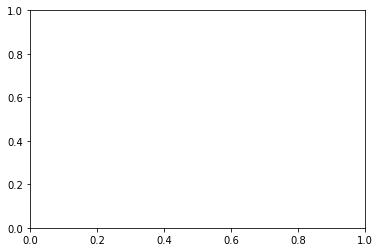

In [27]:
# make some graphs!!!!
import matplotlib.pyplot as plt

figsize = (12, 8)

fig, ax = plt.subplots()

n_groups = 2
index = np.arange(n_groups)
bar_width = 0.30
opacity = 0.4

rects1 = plt.bar(index + bar_width, [np.mean(even_speechace_word_auc), np.mean(odd_speechace_word_auc), np.mean(all_bag_word_auc)], bar_width,
                alpha= opacity,
                color='r',
                label='Word-GP')

rects1 = plt.bar(index + 2*bar_width, [np.mean(even_speechace_phoneme_auc), np.mean(odd_speechace_phoneme_auc)], bar_width,
                alpha = opacity,
                color='b',
                label='Phoneme-GP')

plt.ylabel('Mean AUC of GPR models across conditions', fontsize=12)
plt.xticks(index + (2*bar_width) - 0.15, (["Phoneme-led", "Word-led"]), fontsize=14)
plt.legend(fontsize=14)
plt.tight_layout()
plt.show()



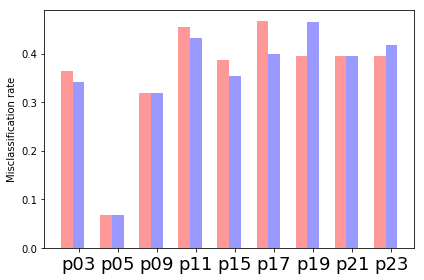

In [44]:
# GRAPH OF BY BAG ODD WORD LOSS

figsize = (12, 8)

fig, ax = plt.subplots()

n_groups = len(odd_bag_word_loss)
index = np.arange(n_groups)
bar_width = 0.30
opacity = 0.4

rects1 = plt.bar(index + bar_width, [np.mean(x) for x in odd_bag_word_loss], bar_width,
                alpha= opacity,
                color='r',
                label='Word Error')

rects1 = plt.bar(index + 2*bar_width, [np.mean(x) for x in odd_bag_phoneme_loss], bar_width,
                alpha = opacity,
                color='b',
                label='Phoneme Error')

plt.ylabel('Misclassification rate')
plt.xticks(index + (2*bar_width), ([x for x in PARTICIPANT_IDS if int(x[1:3]) % 2 == 1]), fontsize=18)
#plt.legend(fontsize=14)
plt.tight_layout()
plt.show()

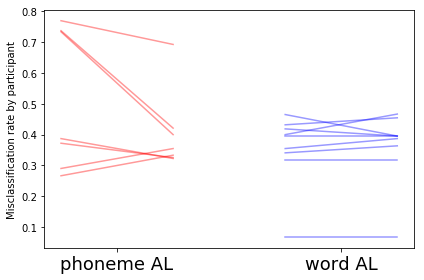

In [47]:
# GRAPH OF LOSS BY BAG AND MODEL
import matplotlib.pyplot as plt

figsize = (12, 8)

#fig, ax = plt.subplots()

n_groups = len(all_bag_word_loss)
bar_width = 0.30
opacity = 0.4

indices = [0,1]

for i in range(0, len(even_bag_word_loss)):    
    plt.plot(indices, [np.mean(even_bag_phoneme_loss[i]), np.mean(even_bag_word_loss[i])],
                alpha= opacity,
                color='r',
                label='Word Error')

for i in range(0, len(odd_bag_word_loss)):    
    plt.plot([x+2 for x in indices], [np.mean(odd_bag_phoneme_loss[i]), np.mean(odd_bag_word_loss[i])],
                alpha= opacity,
                color='b',
                label='Word Error')
        
    
plt.ylabel('Misclassification rate by participant')
plt.xticks([0.5, 2.5], ["phoneme AL", "word AL"], fontsize=18)
plt.tight_layout()
plt.show()



--------------
EVEN WORD, EVEN PHONEME, ODD WORD< ODD PHONEME CORRELATIONS
0.311937116977
0.142940745518
0.209120888887
0.220143060777
-------


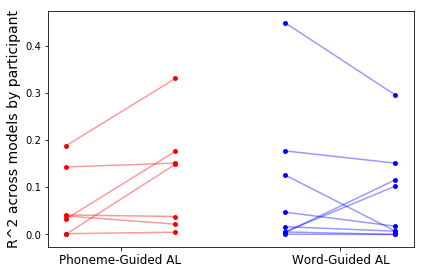

In [71]:
# GRAPH OF CORRELATIONS BY BAG AND MODEL
import matplotlib.pyplot as plt

figsize = (12, 8)

#fig, ax = plt.subplots()

bar_width = 0.30
opacity = 0.4

indices = [0,1]

## Even-odd SpeechAce to Experiment analysis

even_bag_word_corr = []
even_bag_phoneme_corr = []

odd_bag_word_corr = []
odd_bag_phoneme_corr = []

# Basic correlations
for i in range(0, len(even_bag_word_scores)):
    speechace_means = [np.mean(x) / 100.0 for x in even_bag_speechace_scores[i]]
    #print(even_bag_speechace_scores)
    
    if(not len(speechace_means) == len(even_bag_word_scores[i])):
        print("LENGTH DISCREPENCY: " + str(i))
 
    even_bag_word_corr.append(np.corrcoef(even_bag_word_scores[i], speechace_means)[0][1])
    even_bag_phoneme_corr.append(np.corrcoef(even_bag_phoneme_scores[i], speechace_means)[0][1])               
               
for i in range(0, len(odd_bag_word_scores)):
    speechace_means = [np.mean(x) / 100.0 for x in odd_bag_speechace_scores[i]]
    
    if(not len(speechace_means) == len(odd_bag_word_scores[i])):
        print("LENGTH DISCREPENCY: " + str(i))

    odd_bag_word_corr.append(np.corrcoef(odd_bag_word_scores[i], speechace_means)[0][1])
    odd_bag_phoneme_corr.append(np.corrcoef(odd_bag_phoneme_scores[i], speechace_means)[0][1])
    
print('--------------')
print('EVEN WORD, EVEN PHONEME, ODD WORD< ODD PHONEME CORRELATIONS')
print(np.mean(even_bag_word_corr))    
print(np.mean(even_bag_phoneme_corr))    
print(np.mean(odd_bag_word_corr))    
print(np.mean(odd_bag_phoneme_corr))  
print('-------')

even_bag_word_r2 = [x*x for x in even_bag_word_corr]
even_bag_phoneme_r2 = [x*x for x in even_bag_phoneme_corr]
odd_bag_word_r2 = [x*x for x in odd_bag_word_corr]
odd_bag_phoneme_r2 = [x*x for x in odd_bag_phoneme_corr]


for i in range(0, len(even_bag_word_corr)):
    plt.scatter([1 * len([even_bag_word_r2[i]])], [even_bag_word_r2[i]], color='r',s=15)
    plt.scatter([0 * len([even_bag_phoneme_r2[i]])], [even_bag_phoneme_r2[i]], color='r',s=15)
    plt.plot(indices, [even_bag_phoneme_r2[i], even_bag_word_r2[i]],
                alpha= opacity,
                color='r',
                ms=10)

for i in range(0, len(odd_bag_word_corr)):    
    plt.scatter([3 * len([odd_bag_word_r2[i]])], [odd_bag_word_r2[i]], color='b',s=15)
    plt.scatter([2 * len([odd_bag_phoneme_r2[i]])], [odd_bag_phoneme_r2[i]], color='b',s=15)

    plt.plot([x+2 for x in indices], [odd_bag_phoneme_r2[i], odd_bag_word_r2[i]],
                alpha= opacity,
                color='b',
                ms=10)
        
    
plt.ylabel('R^2 across models by participant', fontsize=14)
plt.xticks([0.5, 2.5], ["Phoneme-Guided AL", "Word-Guided AL"], fontsize=12)
plt.tight_layout()
plt.show()

In [8]:
# GRAPH OF CORRELATIONS BY BAG AND MODEL
import matplotlib.pyplot as plt

figsize = (12, 8)

#fig, ax = plt.subplots()

bar_width = 0.30
opacity = 0.4

indices = [0,1]

even_bag_word_corr = []
odd_bag_word_corr = []

even_bag_phoneme_corr = []
odd_bag_phoneme_corr = []

speechace_gt_corr = []
for i in range(0, len(all_bag_gt)):
    speechace_means = [np.mean(x) / 100.0 for x in all_speechace_scores[i]]
#     print('MEANS, SCORES, CORR FOR ROUND ' + str(i))
#     print(speechace_means)
#     print('---------------')
#     print(all_bag_gt[i])
#     print('---------------')
#     print(np.corrcoef(all_bag_gt[i], speechace_means)[0][1])
#     print('---------------')
    speechace_gt_corr.append(np.corrcoef(all_bag_gt[i], speechace_means)[0][1])


for i in range(0, len(even_bag_word_scores)):
    even_bag_word_corr.append(np.corrcoef(even_bag_word_scores[i], even_bag_gt[i])[0][1])
    even_bag_phoneme_corr.append(np.corrcoef(even_bag_phoneme_scores[i], even_bag_gt[i])[0][1])               
               
for i in range(0, len(odd_bag_word_scores)):  
    odd_bag_word_corr.append(np.corrcoef(odd_bag_word_scores[i], odd_bag_gt[i])[0][1])
    odd_bag_phoneme_corr.append(np.corrcoef(odd_bag_phoneme_scores[i], odd_bag_gt[i])[0][1])
               
even_bag_word_r2 = [x*x for x in even_bag_word_corr]
even_bag_phoneme_r2 = [x*x for x in even_bag_phoneme_corr]
odd_bag_word_r2 = [x*x for x in odd_bag_word_corr]
odd_bag_phoneme_r2 = [x*x for x in odd_bag_phoneme_corr]

speechace_gt_r2 = [x*x for x in speechace_gt_corr]

print(speechace_gt_r2)
#print(odd_bag_word_r2)

for i in range(0, len(even_bag_word_corr)):
    plt.scatter([1 * len([even_bag_word_r2[i]])], [even_bag_word_r2[i]], color='r',s=15)
    plt.scatter([0 * len([even_bag_phoneme_r2[i]])], [even_bag_phoneme_r2[i]], color='r',s=15)
    plt.plot(indices, [even_bag_phoneme_r2[i], even_bag_word_r2[i]],
                alpha= opacity,
                color='r',
                label='Word Error')

for i in range(0, len(odd_bag_word_corr)):    
    plt.scatter([3 * len([odd_bag_word_r2[i]])], [odd_bag_word_r2[i]], color='b',s=15)
    plt.scatter([2 * len([odd_bag_phoneme_r2[i]])], [odd_bag_phoneme_r2[i]], color='b',s=15)
    plt.plot([x+2 for x in indices], [odd_bag_phoneme_r2[i], odd_bag_word_r2[i]],
                alpha= opacity,
                color='b',
                label='Word Error')
        
    
plt.ylabel('R^2 across models by participant', fontsize=14)
plt.xticks([0.5, 2.5], ["Phoneme-guided AL", "Word-guided AL"], fontsize=14)
plt.tight_layout()
plt.show()

NameError: name 'all_bag_gt' is not defined

In [48]:
import pronouncing
import csv
import os
import pandas as pd
import numpy as np

"""
This Module handles all aspects of student modeling and assessment
Some code remixed from
http://katbailey.github.io/post/gaussian-processes-for-dummies/
^ Great intro article for rolling your own GP
"""
# pylint: disable=import-error
import random

import math
import operator
import matplotlib.pyplot as plt
import scipy.stats

WPSM_PATH = '/../GameUtils/PronunciationUtils/data/wpsm.csv'

"""
This module serves as the official reference for the word list used in the Tap Game
"""

class Curriculum: # pylint: disable=too-few-public-methods
    """
    This class contains all static final members that correspond to the words we will teach
    """

    #BABY = 'BABY'
    #BATHTUB = 'BATHTUB'
    #BED = "BED"
    #BICYCLE = 'BICYCLE'
    BIRD = 'BIRD'
    BOAT = 'BOAT'
    BOWL = 'BOWL'
    BROOM = 'BROOM'
    BUCKET = 'BUCKET'    
    #BUS = 'BUS'
    CAR = 'CAR'
    #CASTLE = 'CASTLE'
    CAT = 'CAT'
    CHAIR = 'CHAIR'
    CLOCK = 'CLOCK'
    CLOUD = 'CLOUD'
    #COCONUT = 'COCONUT'
    COMPUTER = 'COMPUTER'
    #COUCH = 'COUCH'
    #CRIB = 'CRIB'
    #CUP = 'CUP'
    #DAD = 'DAD'
    DEER = 'DEER'
    DIG = 'DIG'
    DOG = 'DOG'
    DOLPHIN = 'DOLPHIN'
    #DOOR = 'DOOR'
    #DRESS = 'DRESS'
    #DRESSER = 'DRESSER'
    #DUCK = 'DUCK'
    #EAT = 'EAT'
    FATHER = "FATHER"
    #FISH = 'FISH'
    #FISHING = 'FISHING'
    FLOWER = 'FLOWER'    
    #FORK = 'FORK'
    FRIDGE = 'FRIDGE'
    #FROG = 'FROG'
    #GIRAFFE = 'GIRAFFE'
    GOAT = 'GOAT'
    HAT = 'HAT'
    HORSE = 'HORSE'
    IRON = 'IRON'
    #JUMPING = 'JUMPING'
    KETTLE = 'KETTLE'
    LAMP = 'LAMP'
    LION = 'LION'
    MAILBOX = 'MAILBOX'
    MIRROR = 'MIRROR'
    MONKEY = 'MONKEY'
    MOP = 'MOP'
    MOTHER = "MOTHER"
    #MOUNTAIN = 'MOUNTAIN'
    MOUSE = 'MOUSE'
    PAINTING = 'PAINTING'
    PIG = 'PIG'
    PILLOW = 'PILLOW'
    #PLANE = 'PLANE'
    #RABBIT = 'RABBIT'
    ROOSTER = 'ROOSTER'
    #RUNNING = 'RUNNING'
    SEAL = 'SEAL'
    #SEASHELL = 'SEASHELL'
    SHEEP = 'SHEEP'
    SHIRT = 'SHIRT'
    #SHOES = 'SHOES'
    #SOCKS = 'SOCKS'
    SPOON = 'SPOON'
    STOVE = 'STOVE'
    SUN = 'SUN'
    #TABLE = 'TABLE'
    #TELEVISION = 'TELEVISION'
    #TOILET = 'TOILET'
    #TOWEL = 'TOWEL'
    TRACTOR = 'TRACTOR'
    TRAIN = 'TRAIN'
    #TREES = 'TREES'
    UMBRELLA = 'UMBRELLA'
    WINDOW = 'WINDOW'

    def __init__(self):
        return


class ActionSpace(): # pylint: disable=too-few-public-methods
    """
    This class defines constants signifying the potential actions an agent can take
    """
    RING_ANSWER_CORRECT = "RING_ANSWER_CORRECT"
    LATE_RING = "LATE_RING"
    #RING_ANSWER_WRONG = "RING_ANSWER_WRONG"
    DONT_RING = "DONT_RING"

    #REACT_FRUSTRATED = "REACT_FRUSTRATED"

    def __init__(self):
        pass
    
class StudentWordModel(): # pylint: disable=invalid-name,consider-using-enumerate,too-many-instance-attributes

    """
    This class implements a Gaussian Process, intended to model student vocabulary knowledge
    It uses a kernel based on the distance between two words in ConceptNet as well as a
    phonetic distance heuristic.
    pylint's 'invalid-name' checker has been disabled to conform with the notation
    in Rasmussen and Williams
    """

    def __init__(self):

        self.DO_ACTIVE_LEARNING = True

        #fancy python one-liner to read all string attributes off of a class
        self.curriculum = [p for p in dir(Curriculum)
                           if isinstance(getattr(Curriculum, p), str)
                           and not p.startswith('__')]

        self.pronunciation_utils = PronunciationUtils()

        self.loaded_covariance_matrix = np.load(
            os.getcwd() + self.pronunciation_utils.WORD_COVARIANCE_PATH + '.npy')

        # these parameters govern the assumed Gaussian noise added to the child's recorded
        # pronunciation assessment
        self.noise_mu = 0
        self.noise_sigma = .3

        self.X_train = [] # These are persistent lists of training data!
        self.Y_train = []

        self.means = [.5] * len(self.curriculum)  # These are the most recent posteriors
        self.variances = [.3] * len(self.curriculum) # Together they form the Student Model!
        #self.fig = None # Figure for drawing
        #self.plts = None #Plots

        self.n_rows = 10 # needs to be > 1        


    def init_model(self):
        """
        sets up the GP and kernel
        """


    def get_prior(self, n_samples):
        """
        Samples form a prior distribution over the words
        See Algorithm 2.1 in Rasmussen and Williams to follow along with implementation + notation
        """

        # Test data
        # we only care about evaluating the GP at this finite collection of points
        x_test = self.curriculum

        K_ss = self.psdm_kernel(x_test, x_test) #the Kernel Matrix for the words

        # Get cholesky decomposition (square root) of the
        # covariance matrix
        L = np.linalg.cholesky(K_ss + 1e-15 * np.eye(len(x_test)))

        # Sample 3 sets of standard normals for our test points,
        # multiply them by the square root of the covariance matrix
        f_prior = np.dot(L, np.random.normal(size=(len(x_test), n_samples)))
        return f_prior

    def train_and_compute_posterior(self, new_X_train, new_Y_train):
        """
        Takes in a list of labeled X and labeled Y data points and computes a new posterior
        E.g.
        new_X_train = ['BEE', 'SNAKE', 'TIGER']  # these numbers are the word labels
        new_Y_train = [1, 1, 1] # these numbers correspond to full correct pronunciations

        See Algorithm 2.1 in Rasmussen and Williams to follow along with implementation + notation
        """

        Xtest = self.curriculum  # these numbers are just labels

        for i in range(len(new_X_train)):
            self.X_train.append(new_X_train[i])
            self.Y_train.append(new_Y_train[i])

        # compute cov of train set wrt itself + cov of all words wrt all words
#         print("COMPUTING NEW GP POSTERIOR")
#         print("XTRAIN, YTRAIN, MU, VAR")
#         print(self.X_train)
#         print(self.Y_train)
#         print(self.means)
#         print(self.variances)
        K = self.psdm_kernel(self.X_train, self.X_train)
        K_ss = self.psdm_kernel(Xtest, Xtest)

        L = np.linalg.cholesky(K + 0.00005 * np.eye(len(self.X_train)) +
                               ((self.noise_sigma ** 2) * np.eye(len(self.X_train))))

        L_y = np.linalg.solve(L, (list(map(operator.sub, self.Y_train, self.get_mean(self.X_train))))) #pythonic way to subtract two lists #pylint: disable=line-too-long
        #L_y = np.linalg.solve(L, self.Y_train) #zero mean function version
        a = np.linalg.solve(L.T, L_y)

        # Compute the mean at our test points.
        K_s = self.psdm_kernel(self.X_train, Xtest)
        mu = self.get_mean(Xtest) + np.dot(K_s.T, a).reshape(len(self.curriculum), )
        #mu = np.dot(K_s.T, a).reshape(len(self.curriculum), ) #zero mean function version
        v = np.linalg.solve(L, K_s)

        # we only want the diagonal bc we want to know
        # variance of each variable independent of any others
        variance = np.diag(K_ss - np.dot(v.T, v))
        #stdv = np.sqrt(variance)

        self.means = mu
        self.variances = variance
#         print("GP POSTERIOR IS NOW")
#         print("XTRAIN, YTRAIN, MU, VAR")
#         print(self.X_train)
#         print(self.Y_train)
#         print(self.means)
#         print(self.variances)
        return mu, variance


    def get_next_best_word(self, action):
        """
        gives an external caller the next best word to achieve some objective
        Active Learning paradigm is implemented here!
        """


        if self.DO_ACTIVE_LEARNING:
            if action == ActionSpace.RING_ANSWER_CORRECT:

                # choose lowest mean word of words that have not yet been asked about
                lowest_mean = 10.0 # any mean will be lower than initial value 
                lowest_mean_index = 0

                for i in range(0, len(self.means)):
                    if self.means[i] < lowest_mean and self.curriculum[i] not in self.X_train:
                        lowest_mean = self.means[i]
                        lowest_mean_index = i
                chosen_word = self.curriculum[lowest_mean_index]


            elif action == ActionSpace.DONT_RING:

                # choose highest var word
                highest_var = self.variances[0]
                highest_var_index = 0

                for i in range(0, len(self.variances)):
                    if self.variances[i] > highest_var:
                        highest_var = self.variances[i]
                        highest_var_index = i
                chosen_word = self.curriculum[highest_var_index]

        else:
            # randint is inclusive
            chosen_word = self.curriculum[random.randint(0, len(self.curriculum) - 1)]


        return chosen_word

    def rbf_kernel(self, input_a, input_b, length_scale):
        """
        Implements to Radial Basis Function kernel
        """

        sqdist = np.sum(input_a ** 2, 1).reshape(-1, 1) + \
                 np.sum(input_b ** 2, 1) - 2 * np.dot(input_a, input_b.T)
        return np.exp(-.5 * (1 / length_scale) * sqdist)


    def psdm_kernel(self, word_set_a, word_set_b):
        """
        Calculates word matrix covariance via a phonetic-semantic distance metric
        """
        #k = np.empty((len(word_set_a), len(word_set_b),))

        #first, validate that these are all words in our curriculum
        for elem in set().union(word_set_a, word_set_b):
            if not elem in self.curriculum:
                raise Exception(elem + ' is not a word in our curriculum')

        k = np.ones((len(word_set_a), len(word_set_b)))
        for i in range(len(word_set_a)):
            for j in range(len(word_set_b)):
                k[i][j] = self.get_word_cov(word_set_a[i], word_set_b[j])

        return k

    def get_word_cov(self, word1, word2):
        """
        Returns specific values from the global covariance matrix
        """

        index1 = self.curriculum.index(word1)
        index2 = self.curriculum.index(word2)

        #print("covariance between " + word1 + " and " + word2)
        #print(round(self.loaded_covariance_matrix[index1][index2], 3))
        return round(self.loaded_covariance_matrix[index1][index2], 3)

    def get_mean(self, X):
        """
        Implements a mean function for the Gaussian Process. Returns a list of means
        Given a list of words
        """

        #handles both vectors and scalars
        if len(X) > 0:
            return [0.5] * len(X)
        else:
            return 0.5

    def init_plot(self):
        self.fig, self.plts = plt.subplots(self.n_rows, math.ceil(len(self.curriculum)/self.n_rows),
                                           figsize=(15, 10))


    def plot_curricular_distro(self):
        """
        Plots the most recent distribution
        """

        left = 0.125  # the left side of the subplots of the figure
        right = 0.9  # the right side of the subplots of the figure
        bottom = 0.4  # the bottom of the subplots of the figure
        top = 0.9  # the top of the subplots of the figure
        wspace = 1.0  # the amount of width reserved for blank space between subplots
        hspace = 0.2  # the amount of height reserved for white space between subplots

        for i in range(len(self.curriculum)):
            row_index = int(i / (len(self.curriculum) / self.n_rows))
            col_index = int(i % (len(self.curriculum) / self.n_rows))
            self.plts[row_index][col_index].set_xlim([-.5, 1.5])
            self.plts[row_index][col_index].set_ylim([0, 3])

            x = np.linspace(-3, 3, 50)
            self.clear_old_plot_lines()
            self.plts[row_index][col_index].plot(x, scipy.stats.norm.pdf(x, self.means[i],
                                                                         self.variances[i]),
                                                 color='b')
            self.plts[row_index][col_index].set_title(
                self.curriculum[i] + ":\n u= " + str(round(self.means[i], 2)) + ", var= " + str(
                    round(self.variances[i], 2)))

        plt.subplots_adjust(left, bottom, right, top, wspace, hspace)
        self.fig.tight_layout()

        plt.show(block=False)
        self.fig.canvas.flush_events()
        plt.draw()

    def clear_old_plot_lines(self):
        """
        clears the previous lines that were drawn on the graph
        """
        for plotRow in self.plts:
            for plot in plotRow:
                if len(plot.lines) > 1:
                    del plot.lines[0]



class StudentPhonemeModel(): # pylint: disable=invalid-name,consider-using-enumerate,too-many-instance-attributes

    """
    This class implements a Gaussian Process, intended to model student vocabulary knowledge
    It uses a kernel based on a phonetic distance heuristic.
    pylint's 'invalid-name' checker has been disabled to conform with the notation
    in Rasmussen and Williams
    """

    def __init__(self):

        self.DO_ACTIVE_LEARNING = True

        # load all phonemes into a list
        
        df = pd.read_csv(os.getcwd() + WPSM_PATH, sep=',', header=0, index_col=0)
        arpabet_phonemes = df.keys()
        self.curriculum = list(arpabet_phonemes) # for phoneme model, this is the list of arpabet phonemes
        self.word_list = [p for p in dir(Curriculum)
                           if isinstance(getattr(Curriculum, p), str)
                           and not p.startswith('__')] #this is the list of words, used for active learning selection

        self.pronunciation_utils = PronunciationUtils()

        self.loaded_covariance_matrix = np.load(
            os.getcwd() + self.pronunciation_utils.ARPABET_COVARIANCE_PATH + '.npy')

        # these parameters govern the assumed Gaussian noise added to the child's recorded
        # pronunciation assessment
        self.noise_mu = 0
        self.noise_sigma = .3

        self.X_train = [] # These are persistent lists of training data!
        self.Y_train = []
        self.words_so_far = [] # In order to do the active learning properly, we need to maintain a list of what words
                               # have been asked already

        self.means = [.5] * len(self.curriculum)  # These are the most recent posteriors
        self.variances = [.3] * len(self.curriculum) # Together they form the Student Model!
        #self.fig = None # Figure for drawing
        #self.plts = None #Plots

        self.n_rows = 5 # needs to be > 1        


    def init_model(self):
        """
        sets up the GP and kernel
        """


    def get_prior(self, n_samples):
        """
        Samples form a prior distribution over the words
        See Algorithm 2.1 in Rasmussen and Williams to follow along with implementation + notation
        """

        # Test data
        # we only care about evaluating the GP at this finite collection of points
        x_test = self.curriculum

        K_ss = self.phoneme_distance_kernel(x_test, x_test) #the Kernel Matrix for the words

        # Get cholesky decomposition (square root) of the
        # covariance matrix
        L = np.linalg.cholesky(K_ss + 1e-15 * np.eye(len(x_test)))

        # Sample 3 sets of standard normals for our test points,
        # multiply them by the square root of the covariance matrix
        f_prior = np.dot(L, np.random.normal(size=(len(x_test), n_samples)))
        return f_prior

    def train_and_compute_posterior(self, new_X_train, new_Y_train):
        """
        Takes in a list of labeled X and labeled Y data points and computes a new posterior
        E.g.
        new_X_train = ['K', 'AE', 'T']  # these numbers are the phoneme labels
        new_Y_train = [1, 1, 1] # these numbers correspond to phoneme scores

        See Algorithm 2.1 in Rasmussen and Williams to follow along with implementation + notation
        """

        Xtest = self.curriculum  # these numbers are just labels

        for i in range(len(new_X_train)):
            self.X_train.append(new_X_train[i])
            self.Y_train.append(new_Y_train[i])

        # compute cov of train set wrt itself + cov of all words wrt all words
#         print("COMPUTING NEW GP POSTERIOR")
#         print("XTRAIN, YTRAIN, MU, VAR")
#         print(self.X_train)
#         print(self.Y_train)
#         print(self.means)
#         print(self.variances)
        K = self.phoneme_distance_kernel(self.X_train, self.X_train)
        K_ss = self.phoneme_distance_kernel(Xtest, Xtest)

        cholesky_mtx = (K + 0.00005 * np.eye(len(self.X_train)) +
                               ((self.noise_sigma ** 2) * np.eye(len(self.X_train))))
        #print(cholesky_mtx)
        # cholesky_mtx[cholesky_mtx > 1.0] = 1.0
        # print(cholesky_mtx)
        L = np.linalg.cholesky(cholesky_mtx)

        L_y = np.linalg.solve(L, (list(map(operator.sub, self.Y_train, self.get_mean(self.X_train))))) #pythonic way to subtract two lists #pylint: disable=line-too-long
        #L_y = np.linalg.solve(L, self.Y_train) #zero mean function version
        a = np.linalg.solve(L.T, L_y)

        # Compute the mean at our test points.
        K_s = self.phoneme_distance_kernel(self.X_train, Xtest)
        mu = self.get_mean(Xtest) + np.dot(K_s.T, a).reshape(len(self.curriculum), )
        #mu = np.dot(K_s.T, a).reshape(len(self.curriculum), ) #zero mean function version
        v = np.linalg.solve(L, K_s)

        # we only want the diagonal bc we want to know
        # variance of each variable independent of any others
        variance = np.diag(K_ss - np.dot(v.T, v))
        #stdv = np.sqrt(variance)

        self.means = mu
        self.variances = variance

#         print("GP POSTERIOR IS NOW")
#         print("XTRAIN, YTRAIN, MU, VAR")        

#         print(self.X_train)
#         print(self.Y_train)
#         print(self.means)
#         print(self.variances)
        return self.means, self.variances


    def get_next_best_word(self, action):
        """
        gives an external caller the next best word to achieve some objective
        Active Learning paradigm is implemented here!
        """


        if self.DO_ACTIVE_LEARNING:

            print("WORDS SO FAR IS")
            print(self.words_so_far)

            if action == ActionSpace.RING_ANSWER_CORRECT:

                # choose lowest mean word of words that have not yet been asked about
                lowest_mean = 10.0 # any mean will be lower than initial value
                lowest_mean_index = 0


                for i in range(0, len(self.word_list)):
                    candidate_mean = self.get_phoneme_mean(self.word_list[i])
                    if candidate_mean < lowest_mean and self.word_list[i] not in self.words_so_far:
                        lowest_mean = candidate_mean
                        lowest_mean_index = i
                chosen_word = self.word_list[lowest_mean_index]
                print("CHOSEN WORD WAS")
                print(chosen_word)
                print("W MEAN OF " + str(lowest_mean))


            elif action == ActionSpace.DONT_RING:

                # choose highest var word
                highest_var = -10
                highest_var_index = 0

                for i in range(0, len(self.word_list)):
                    candidate_var = self.get_phoneme_var(self.word_list[i])
                    if candidate_var > highest_var and self.word_list[i] not in self.words_so_far:
                        highest_var = candidate_var
                        highest_var_index = i
                chosen_word = self.word_list[highest_var_index]
                print("CHOSEN WORD WAS")
                print(chosen_word)
                print("W VAR OF " + str(highest_var))

        else:
            # randint is inclusive
            chosen_word = self.curriculum[random.randint(0, len(self.curriculum) - 1)]


        return chosen_word

    def rbf_kernel(self, input_a, input_b, length_scale):
        """
        Implements to Radial Basis Function kernel
        """

        sqdist = np.sum(input_a ** 2, 1).reshape(-1, 1) + \
                 np.sum(input_b ** 2, 1) - 2 * np.dot(input_a, input_b.T)
        return np.exp(-.5 * (1 / length_scale) * sqdist)


    def phoneme_distance_kernel(self, phoneme_set_a, phoneme_set_b):
        """
        Calculates word matrix covariance via a phonetic-ONLY distance metric
        """
        #k = np.empty((len(word_set_a), len(word_set_b),))

        #first, validate that these are all words in our curriculum
        for elem in set().union(phoneme_set_a, phoneme_set_b):
            if not elem in self.curriculum:
                raise Exception(elem + ' is not a phoneme in our curriculum')

        k = np.ones((len(phoneme_set_a), len(phoneme_set_b)))
        for i in range(len(phoneme_set_a)):
            for j in range(len(phoneme_set_b)):
                k[i][j] = self.get_phoneme_cov(phoneme_set_a[i], phoneme_set_b[j])

        return k

    def get_phoneme_cov(self, phoneme1, phoneme2):
        """
        Returns specific values from the phoneme covariance matrix
        """

        index1 = self.curriculum.index(phoneme1)
        index2 = self.curriculum.index(phoneme2)

        #print("covariance between " + phoneme1 + " and " + phoneme2)
        #print(round(self.loaded_covariance_matrix[index1][index2], 3))
        return round(self.loaded_covariance_matrix[index1][index2], 3)

    def get_mean(self, X):
        """
        Implements a mean function for the Gaussian Process. Returns a list of means
        Given a list of words
        """

        #handles both vectors and scalars
        if len(X) > 0:
            return [0.5] * len(X)
        else:
            return 0.5

    def get_phoneme_mean(self, word):
        """
        gets the phoneme-based mean of a word, given the current model
        """
        phonemes_raw = pronouncing.phones_for_word(word.lower())[0].split(' ')
        phonemes = [''.join(filter(lambda c: not c.isdigit(), pho)) for pho in phonemes_raw]
        
        phoneme_means = []
        for i in range(0, len(phonemes)):
            for j in range(0, len(self.curriculum)):
                if phonemes[i] == self.curriculum[j]:
                    phoneme_means.append(self.means[j])        
        return np.mean(phoneme_means)


    def get_phoneme_var(self, word):
        """
        gets the phoneme-based variance of a word, given the current model
        """
        phonemes_raw = pronouncing.phones_for_word(word.lower())[0].split(' ')
        phonemes = [''.join(filter(lambda c: not c.isdigit(), pho)) for pho in phonemes_raw]
        
        phoneme_vars = []
        for i in range(0, len(phonemes)):
            for j in range(0, len(self.curriculum)):
                if phonemes[i] == self.curriculum[j]:
                    phoneme_vars.append(self.variances[j])        
        return np.mean(phoneme_vars)

    def init_plot(self):
        self.fig, self.plts = plt.subplots(self.n_rows, math.ceil(len(self.curriculum)/self.n_rows),
                                           figsize=(15, 10))

    def plot_curricular_distro(self):
        """
        Plots the most recent distribution
        """

        left = 0.125  # the left side of the subplots of the figure
        right = 0.9  # the right side of the subplots of the figure
        bottom = 0.4  # the bottom of the subplots of the figure
        top = 0.9  # the top of the subplots of the figure
        wspace = 1.0  # the amount of width reserved for blank space between subplots
        hspace = 0.2  # the amount of height reserved for white space between subplots

        for i in range(len(self.curriculum)):
            row_index = int(i / (len(self.curriculum) / self.n_rows))
            col_index = int(i % (len(self.curriculum) / self.n_rows))
            self.plts[row_index][col_index].set_xlim([-.5, 1.5])
            self.plts[row_index][col_index].set_ylim([0, 3])

            x = np.linspace(-3, 3, 50)
            self.clear_old_plot_lines()
            self.plts[row_index][col_index].plot(x, scipy.stats.norm.pdf(x, self.means[i],
                                                                         self.variances[i]),
                                                 color='b')
            self.plts[row_index][col_index].set_title(
                self.curriculum[i] + ":\n u= " + str(round(self.means[i], 2)) + ", var= " + str(
                    round(self.variances[i], 2)))

        plt.subplots_adjust(left, bottom, right, top, wspace, hspace)
        self.fig.tight_layout()

        plt.show(block=False)
        self.fig.canvas.flush_events()
        plt.draw()

    def clear_old_plot_lines(self):
        """
        clears the previous lines that were drawn on the graph
        """
        for plotRow in self.plts:
            for plot in plotRow:
                if len(plot.lines) > 1:
                    del plot.lines[0]


class PronunciationUtils:
	"""
	This class contains functions that handles pronunciation results obtained from SpeechACE
	"""

	SCORE_THRESHOLD = 70  # Score threshold we use to determine whether a word was passed or not
	# by SpeechAce

	PHONEME_SUB_COST_PATH = '/../GameUtils/PronunciationUtils/data/phoneme_subsitution_costs'
	WEIGHTED_LEV_DISTANCE_PATH = '/../GameUtils/PronunciationUtils/data/weighted_lev_distances'
	GLOVE_DISTANCE_PATH = '/../GameUtils/PronunciationUtils/data/glove_distances'
	ARPABET_COVARIANCE_PATH = '/../GameUtils/PronunciationUtils/data/arpabet_covariance_matrix'
	WORD_COVARIANCE_PATH = '/../GameUtils/PronunciationUtils/data/covariance_matrix'

	def __init__(self):

		# loads arpabet mapping, an IPA-like representation of phonemes for computer processing
		self.load_arpabet_mapping()

		# load nettalk.data dictionary, which is used to alignment word graphemes and phonemes
		self.load_nettalk_dataset()

		self.current_word = None
		self.pho_results = None
		self.syl_results = None

	def process_speechace_word_results(self, word_results):
		"""
		takes in results from speechace and analyze the user's pronunciation accuracy
		"""

		if word_results is None:
			return [[''], ['0']]
		else:
			self.current_word = word_results["word"]  # .encode("ascii","ignore")
			self.pho_results = word_results["phone_score_list"]
			self.syl_results = word_results["syllable_score_list"]
			#print(self.current_word)            
			#print(self.pho_results)

			phoneme_acc = self.phoneme_based_accuracy(self.pho_results)
			#print(phoneme_acc)
			#syllable_acc = self.syllable_based_accuracy(self.syl_results)

		return self.get_letters_and_pass(phoneme_acc) # pass syllable_acc to analyze syllables

	def phoneme_based_accuracy(self, phoneme_results):
		"""
		checks which graphemes pass the accuracy threshold
		return: a tuple that contains three lists (graphemes, phonemes, and
		bool values indicating whether the graphemes pass threshold)
		"""
		
		graphemes, phonemes = self.phonemes2graphemes(self.current_word)
		pass_list = []
		score_list = []

		phoneme_res_index = 0
		for i in range(len(phonemes)):
			#print(phoneme_results[phoneme_res_index]["phone"].upper() + " COMPARED TO " + phonemes[i])
			if phoneme_results[phoneme_res_index]["phone"].upper() == phonemes[i]:
				score = phoneme_results[phoneme_res_index]["quality_score"]
				phoneme_res_index += 1
				if score >= PronunciationUtils.SCORE_THRESHOLD:
					pass_list.append("1")
				else:
					pass_list.append("0")
				score_list.append(score)
			else:
				print(phoneme_results[phoneme_res_index]["phone"].upper() + " DID NOT MATCH " + phonemes[i])
				pass_list.append("0")
				score_list.append(0.0)

		return (graphemes, phonemes, pass_list, score_list)

	# def syllable_based_accuracy(self, syllable_results):
	#     """
	#     check which syllables pass the accuracy threshold
	#     return: a tuple that contains two lists (syllables and bool values)
	#     """
	#
	#     syllable_list = []
	#     pass_list = []
	#
	#     for i in range(len(syllable_results)):
	#         syllable_list.append(syllable_results[i]["letters"])
	#         score = syllable_results[i]["quality_score"]
	#         if score >= SCORE_THRESHOLD:
	#             pass_list.append(True)
	#         else:
	#             pass_list.append(False)
	#
	#     return (syllable_list, pass_list)


	def get_letters_and_pass(self, phoneme_acc):
		"""
		Associates phoneme scores with graphemes and whether they passed
		Also sends the speechace scores (indexed by phoneme) back for analysis
		"""

		graphemes, phonemes, passes, phoneme_scores = phoneme_acc
		letters = []
		passed = []

		for i in range(len(graphemes)):
			if len(graphemes[i]) > 1:  # some graphemes have multiple letters, like 'CH'
				for j in graphemes[i]:
					letters.append(j)
					passed.append(passes[i])
					
			else:
				letters.append(graphemes[i])
				passed.append(passes[i])				

		return letters, passed, phoneme_scores


	def load_arpabet_mapping(self):
		"""
		Loads the arpabet mapping, which lists all the phonemes under consideration
		"""

		# dictionary to store arpabet mapping
		self.arpabet_map = dict()
		with open('../GameUtils/PronunciationUtils/data/arpabet_mapping.csv', 'r') as csvfile:
			spamreader = csv.reader(csvfile, delimiter=',')
			for row in spamreader:
				# row[1] is CMU arpabet, row[0] is modified version of arpabet for NETTalk database
				self.arpabet_map.update({row[1]: row[0]})

	def load_nettalk_dataset(self):
		"""
		nettalk contains phonetic transcription of 20,008 english words
		dataset can be accessed at:
https://archive.ics.uci.edu/ml/machine-learning-databases/undocumented/connectionist-bench/nettalk/
		"""

		self.nettalk_dataset = dict()
		with open('../GameUtils/PronunciationUtils/data/nettalk.data', 'r') as csvfile:
			spamreader = csv.reader(csvfile, delimiter='\t')
			for row in spamreader:
				# row[0]: word. row[1]: phonetic transcription
				self.nettalk_dataset.update({row[0]: row[1]})

	def phonemes2graphemes(self, word):
		"""
		align a given word's graphemes with its phonemes using Nettalk
		"""

		#print(word)
		#print(pronouncing.phones_for_word(word.lower()))

		# need to use lowercase form of word for pronouncing and nettalk dict lookup
		phonemes_raw = pronouncing.phones_for_word(word.lower())[0].split(' ')
		phonemes = [''.join(filter(lambda c: not c.isdigit(), pho)) for pho in phonemes_raw]

		# find the phoneme-grapheme alignment in Nettalk database
		# get exact alignment
		phos = self.nettalk_dataset[word.lower()]

		print(phos)

		phos = list(phos)
		graphemes = list()
		grapheme = ''
		for i in range(0, len(phos), 1):
			if phos[i] != '-':
				# one phoneme is matched to one letter
				if grapheme != '':
					graphemes.append(grapheme)
				grapheme = word[i]
			else:
				# one phoneme is matched to an additional letter
				grapheme += word[i]
		graphemes.append(grapheme)

		# TODO: This is hack-ey and should not be done. Let this comment stand as a reminder
		# TODO: that sometimes phonemes and graphemes dont line up right...

		# For some reason camera doesn't line up phonemes and graphemes correctly
		# if word == "camera":
		#	graphemes = ['c', 'a', 'm', 'er', 'a']

		#print([graphemes, phonemes])
		return [graphemes, phonemes]

	def get_phonetic_similarity_rep(self, word):
		"""
		convert a given word into a unique phonetic transcription,
		which allows for measuring phonetic similarity with other words
		output: a phonetic string for the input word. each letter in the string
		corresponds uniquely to a phone
		"""

		phonemes_raw = pronouncing.phones_for_word(word.lower())[0].split(' ')
		phonemes = [''.join(filter(lambda c: not c.isdigit(), pho)) for pho in phonemes_raw]
		#print(phonemes_raw)
		output = ''
		for phoneme in phonemes:
			if phoneme in self.arpabet_map:
				output += self.arpabet_map[phoneme]
			else:
				print("phone ( " + phoneme + " ) does not exist in arpabet map")
				break
		
		#print(word + " become " + output)
		return output

